In [ ]:
!pip install -q ray[RLlib]

This notebook compares three separate methods for calculating the probability distributions of state values.

 - [Beta-NLL](https://arxiv.org/pdf/2203.09168)
   - Maximizes the log likelihood of datapoints, with a hyperparameter downweighting extreme cases
 - Evidential PPO
   - Maximizes the log of marginal likelihood (AKA [*model evidence*](https://en.wikipedia.org/wiki/Marginal_likelihood)), as seen in [equation 2](https://arxiv.org/html/2503.01468v2)
 - My own custom loss function, developed while researching this problem
   - Maximizes the log of the probability ratio between the predicted distribution means and the value targets, under the predicted distribution.

In [2]:
# @title FixedAddOneTsToEpisodesAndTruncate
# Fixes a bug in RLLib's codebase that impacts environments with terminal rewards. Should be pushed to Master soon, so don't worry about it.
from typing import Any, Dict, List, Optional

from ray.rllib.connectors.connector_v2 import ConnectorV2
from ray.rllib.core.columns import Columns
from ray.rllib.core.rl_module.rl_module import RLModule
from ray.rllib.env.multi_agent_episode import MultiAgentEpisode
from ray.rllib.utils.annotations import override
from ray.rllib.utils.postprocessing.episodes import add_one_ts_to_episodes_and_truncate
from ray.rllib.utils.typing import EpisodeType
from ray.util.annotations import PublicAPI


@PublicAPI(stability="alpha")
class FixedAddOneTsToEpisodesAndTruncate(ConnectorV2):
    """Adds an artificial timestep to all incoming episodes at the end.

    In detail: The last observations, infos, actions, and all `extra_model_outputs`
    will be duplicated and appended to each episode's data. An extra 0.0 reward
    will be appended to the episode's rewards. The episode's timestep will be
    increased by 1. Also, adds the truncated=True flag to each episode if the
    episode is not already done (terminated or truncated).

    Useful for value function bootstrapping, where it is required to compute a
    forward pass for the very last timestep within the episode,
    i.e. using the following input dict: {
      obs=[final obs],
      state=[final state output],
      prev. reward=[final reward],
      etc..
    }

    .. testcode::

        from ray.rllib.connectors.learner import AddOneTsToEpisodesAndTruncate
        from ray.rllib.env.single_agent_episode import SingleAgentEpisode
        from ray.rllib.utils.test_utils import check

        # Create 2 episodes (both to be extended by one timestep).
        episode1 = SingleAgentEpisode(
            observations=[0, 1, 2],
            actions=[0, 1],
            rewards=[0.0, 1.0],
            terminated=False,
            truncated=False,
            len_lookback_buffer=0,
        ).to_numpy()
        check(len(episode1), 2)
        check(episode1.is_truncated, False)

        episode2 = SingleAgentEpisode(
            observations=[0, 1, 2, 3, 4, 5],
            actions=[0, 1, 2, 3, 4],
            rewards=[0.0, 1.0, 2.0, 3.0, 4.0],
            terminated=True,  # a terminated episode
            truncated=False,
            len_lookback_buffer=0,
        ).to_numpy()
        check(len(episode2), 5)
        check(episode2.is_truncated, False)
        check(episode2.is_terminated, True)

        # Create an instance of this class.
        connector = AddOneTsToEpisodesAndTruncate()

        # Call the connector.
        shared_data = {}
        _ = connector(
            rl_module=None,  # Connector used here does not require RLModule.
            batch={},
            episodes=[episode1, episode2],
            shared_data=shared_data,
        )
        # Check on the episodes. Both of them should now be 1 timestep longer.
        check(len(episode1), 3)
        check(episode1.is_truncated, True)
        check(len(episode2), 6)
        check(episode2.is_truncated, False)
        check(episode2.is_terminated, True)
    """

    @override(ConnectorV2)
    def __call__(
        self,
        *,
        rl_module: RLModule,
        batch: Dict[str, Any],
        episodes: List[EpisodeType],
        explore: Optional[bool] = None,
        shared_data: Optional[dict] = None,
        **kwargs,
    ) -> Any:
        # Build the loss mask to make sure the extra added timesteps do not influence
        # the final loss and fix the terminateds and truncateds in the batch.

        # For proper v-trace execution, the rules must be as follows:
        # Legend:
        # T: terminal=True
        # R: truncated=True
        # B0: bootstrap with value 0 (also: terminal=True)
        # Bx: bootstrap with some vf-computed value (also: terminal=True)

        # batch: - - - - - - - T B0- - - - - R Bx- - - - R Bx
        # mask : t t t t t t t t f t t t t t t f t t t t t f

        # TODO (sven): Same situation as in TODO below, but for multi-agent episode.
        #  Maybe add a dedicated connector piece for this task?
        # We extend the MultiAgentEpisode's ID by a running number here to make sure
        # we treat each MAEpisode chunk as separate (for potentially upcoming v-trace
        # and LSTM zero-padding) and don't mix data from different chunks.
        if isinstance(episodes[0], MultiAgentEpisode):
            for i, ma_episode in enumerate(episodes):
                ma_episode.id_ += "_" + str(i)
                # Also change the underlying single-agent episode's
                # `multi_agent_episode_id` properties.
                for sa_episode in ma_episode.agent_episodes.values():
                    sa_episode.multi_agent_episode_id = ma_episode.id_

        for i, sa_episode in enumerate(
            self.single_agent_episode_iterator(episodes, agents_that_stepped_only=False)
        ):
            # TODO (sven): This is a little bit of a hack: By extending the Episode's
            #  ID, we make sure that each episode chunk in `episodes` is treated as a
            #  separate episode in the `self.add_n_batch_items` below. Some algos (e.g.
            #  APPO) may have >1 episode chunks from the same episode (same ID) in the
            #  training data, thus leading to a malformatted batch in case of
            #  RNN-triggered zero-padding of the train batch.
            #  For example, if e1 (id=a len=4) and e2 (id=a len=5) are two chunks of the
            #  same episode in `episodes`, the resulting batch would have an additional
            #  timestep in the middle of the episode's "row":
            #  {  "obs": {
            #    ("a", <- eps ID): [0, 1, 2, 3 <- len=4, [additional 1 ts (bad)],
            #                       0, 1, 2, 3, 4 <- len=5, [additional 1 ts]]
            #  }}
            sa_episode.id_ += "_" + str(i)

            len_ = len(sa_episode)

            # Extend all episodes by one ts.
            add_one_ts_to_episodes_and_truncate([sa_episode])

            loss_mask = [True for _ in range(len_)] + [False]
            self.add_n_batch_items(
                batch,
                Columns.LOSS_MASK,
                loss_mask,
                len_ + 1,
                sa_episode,
            )

            terminateds = [
                False for _ in range(len_)
            ] + [  # Avoid ignoring last-step rewards when lambda=0
                bool(sa_episode.is_terminated)
            ]  # Use computed value for truncated eps.  # extra timestep
            self.add_n_batch_items(
                batch,
                Columns.TERMINATEDS,
                terminateds,
                len_ + 1,
                sa_episode,
            )

        # Signal to following connector pieces that the loss-mask which masks out
        # invalid episode ts (for the extra added ts at the end) has already been
        # added to `data`.
        shared_data["_added_loss_mask_for_valid_episode_ts"] = True

        return batch

In [3]:
# @title Imports
import numpy as np
import functools

from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.core.rl_module.multi_rl_module import MultiRLModuleSpec
from ray.rllib.core.rl_module.rl_module import RLModuleSpec
from ray.rllib.algorithms.ppo.torch.default_ppo_torch_rl_module import DefaultPPOTorchRLModule

from ray.rllib.examples.rl_modules.classes.action_masking_rlm import (
    ActionMaskingTorchRLModule,
)
from ray.rllib.utils.metrics import (
    TRAINING_ITERATION_TIMER,
)

from ray.rllib.utils.metrics import ENV_RUNNER_RESULTS, EVALUATION_RESULTS

import torch
from ray.rllib.core.columns import Columns
from ray.rllib.policy.sample_batch import DEFAULT_POLICY_ID

from ray.rllib.connectors.learner.add_one_ts_to_episodes_and_truncate import (
    AddOneTsToEpisodesAndTruncate,
)

ACTION_MASK = "action_mask"
OBSERVATIONS = "observations"

2026-01-31 07:42:58,274	WARNING ppo_torch_rl_module.py:8 -- DeprecationWarning: `ray.rllib.algorithms.ppo.torch.ppo_torch_rl_module.PPOTorchRLModule` has been deprecated. Use `ray.rllib.algorithms.ppo.torch.default_ppo_torch_rl_module.DefaultPPOTorchRLModule` instead. This will raise an error in the future!


## Code

### Env/utility code

In [4]:
# @title TwoStepStochasticBandits
import gymnasium as gym
from gymnasium.spaces import Box, Discrete

class TwoStepStochasticBandits(gym.Env):
    '''
      Take a series of (u, var) doors. For each door, there is a state after the first state. In this next state, action zero is taken and a reward is issued from the corresponding distribution. The game then terminates.
    '''
    def __init__(self, config={}):
        super().__init__()
        self.doors = config['doors'] if 'doors' in config else [(0.5,0.7),(0.4,0.1),(0.6, 1)]
        self.sc = len(self.doors)+1
        self.observation_space = gym.spaces.Dict({
            ACTION_MASK: Box(0.0, 1.0, shape=(self.sc,)), # 0=finish, 1...=goto state
            OBSERVATIONS: Box(0.0, 1.0, shape=(self.sc,)),
        })
        self.action_space = Discrete(self.sc)

    def get_obs(self):
        obs, am = np.zeros((self.sc),), np.zeros((self.sc),)
        obs[self.state] = 1.
        am[0] = 1. # If state != 0, can only take action 0.
        if (self.state==0):
          am = 1. - am # In state zero, can take every action except 0.
        return {
            ACTION_MASK: am,
            OBSERVATIONS: obs,
        }

    def reset(self, *, seed=None, options=None):
        self.state = 0 # position of the player
        return self.get_obs(), {}  # <- empty infos dict

    def step(self, action):
        reward = 0
        terminated = False
        if (self.state==0):
          self.state=action
        else:
          terminated = True
          u, sd = self.doors[self.state-1] # state zero is the starting state
          reward = np.random.normal(u, sd)
        return self.get_obs(), reward, terminated, False, {}

In [5]:
# @title LogActionsCallback
from collections import defaultdict

import numpy as np

from ray.rllib.callbacks.callbacks import RLlibCallback
from ray.rllib.core.rl_module.rl_module import RLModuleSpec
from ray.rllib.core.rl_module.multi_rl_module import MultiRLModuleSpec
from ray.rllib.utils.metrics import ENV_RUNNER_RESULTS
from ray.rllib.core import (
    COMPONENT_RL_MODULE,
    COMPONENT_LEARNER,
    COMPONENT_LEARNER_GROUP,
)

class LogActionsCallback(RLlibCallback):
    def __init__(self, action_lambda):
      self.action_lambda = action_lambda

    def on_episode_end(self, *, episode, env_runner, metrics_logger, env, env_index, rl_module, **kwargs, ) -> None:
        action = episode.get_actions()[0]
        for i in self.action_lambda(): # Rates of each action
          metrics_logger.log_value(
              f"player_action_{i}",
              action==i,
              reduce='mean'
          )

### Algorithm-related code

In [16]:
# @title ProbValueLearner
import abc
from typing import Any, Dict

from ray.rllib.algorithms.ppo.ppo import (
    LEARNER_RESULTS_CURR_ENTROPY_COEFF_KEY,
    LEARNER_RESULTS_KL_KEY,
    PPOConfig,
)
from ray.rllib.connectors.learner import (
    AddOneTsToEpisodesAndTruncate,
    GeneralAdvantageEstimation,
)
from ray.rllib.core.learner.learner import Learner
from ray.rllib.core.rl_module.apis.value_function_api import ValueFunctionAPI
from ray.rllib.utils.annotations import (
    override,
    OverrideToImplementCustomLogic_CallToSuperRecommended,
)
from ray.rllib.utils.lambda_defaultdict import LambdaDefaultDict
from ray.rllib.utils.metrics import (
    NUM_ENV_STEPS_SAMPLED_LIFETIME,
    NUM_MODULE_STEPS_TRAINED,
)
from ray.rllib.utils.numpy import convert_to_numpy
from ray.rllib.utils.schedules.scheduler import Scheduler
from ray.rllib.utils.typing import ModuleID, TensorType


class ProbValueLearner(Learner):

    @override(Learner)
    def build(self) -> None:
        super().build() # We call Learner's build function, not PPOLearner's
        learner_config_dict = self.config.learner_config_dict

        # Dict mapping module IDs to the respective entropy Scheduler instance.
        self.entropy_coeff_schedulers_per_module: Dict[
            ModuleID, Scheduler
        ] = LambdaDefaultDict(
            lambda module_id: Scheduler(
                fixed_value_or_schedule=(
                    self.config.get_config_for_module(module_id).entropy_coeff
                ),
                framework=self.framework,
                device=self._device,
            )
        )

        # Set up KL coefficient variables (per module).
        # Note that the KL coeff is not controlled by a Scheduler, but seeks
        # to stay close to a given kl_target value.
        self.curr_kl_coeffs_per_module: Dict[ModuleID, TensorType] = LambdaDefaultDict(
            lambda module_id: self._get_tensor_variable(
                self.config.get_config_for_module(module_id).kl_coeff
            )
        )
        # Select a loss scheme
        self.critic_loss_strategy = self.config.learner_config_dict["critic_loss_strategy"]
        # Select an advantage calculation strategy
        self.adv_calc_strategy = self.config.learner_config_dict["adv_calc_strategy"]
        # Extend all episodes by one artificial timestep to allow the value function net
        # to compute the bootstrap values (and add a mask to the batch to know, which
        # slots to mask out).
        if (
            self._learner_connector is not None
            and self.config.add_default_connectors_to_learner_pipeline
        ):
            # Before anything, add one ts to each episode (and record this in the loss
            # mask, so that the computations at this extra ts are not used to compute
            # the loss).
            self._learner_connector.prepend(FixedAddOneTsToEpisodesAndTruncate())
            # At the end of the pipeline (when the batch is already completed), add the
            # GAE connector, which performs a vf forward pass, then computes the GAE
            # computations, and puts the results of this (advantages, value targets)
            # directly back in the batch. This is then the batch used for
            # `forward_train` and `compute_losses`.
            self._learner_connector.append(
                GAE_ProbValue(
                    gamma=self.config.gamma,
                    lambda_=self.config.lambda_,
                    adv_calc_strategy=self.adv_calc_strategy
                )
            )

    @override(Learner)
    def remove_module(self, module_id: ModuleID, **kwargs):
        marl_spec = super().remove_module(module_id, **kwargs)
        if (module_id in self.entropy_coeff_schedulers_per_module):
          # Only for modules with entropy terms (no shared critics / curiousity modules)
          self.entropy_coeff_schedulers_per_module.pop(module_id, None)
          self.curr_kl_coeffs_per_module.pop(module_id, None)
        return marl_spec

    @OverrideToImplementCustomLogic_CallToSuperRecommended
    @override(Learner)
    def after_gradient_based_update(
        self,
        *,
        timesteps: Dict[str, Any],
    ) -> None:
        super().after_gradient_based_update(timesteps=timesteps)

        for module_id, module in self.module._rl_modules.items():
            if (module_id not in self.entropy_coeff_schedulers_per_module):
              continue
            config = self.config.get_config_for_module(module_id)
            # Update entropy coefficient via our Scheduler.
            new_entropy_coeff = self.entropy_coeff_schedulers_per_module[
                module_id
            ].update(timestep=timesteps.get(NUM_ENV_STEPS_SAMPLED_LIFETIME, 0))
            self.metrics.log_value(
                (module_id, LEARNER_RESULTS_CURR_ENTROPY_COEFF_KEY),
                new_entropy_coeff,
                window=1,
            )
            if (
                config.use_kl_loss
                and self.metrics.peek((module_id, NUM_MODULE_STEPS_TRAINED), default=0)
                > 0
                and (module_id, LEARNER_RESULTS_KL_KEY) in self.metrics
            ):
                kl_loss = convert_to_numpy(
                    self.metrics.peek((module_id, LEARNER_RESULTS_KL_KEY))
                )
                self._update_module_kl_coeff(
                    module_id=module_id,
                    config=config,
                    kl_loss=kl_loss,
                )

    @classmethod
    @override(Learner)
    def rl_module_required_apis(cls) -> list[type]:
        # We no longer require value functions for modules, since there's a central critic
        return []

    @abc.abstractmethod
    def _update_module_kl_coeff(
        self,
        *,
        module_id: ModuleID,
        config: PPOConfig,
        kl_loss: float,
    ) -> None:
        """Dynamically update the KL loss coefficients of each module.

        The update is completed using the mean KL divergence between the action
        distributions current policy and old policy of each module. That action
        distribution is computed during the most recent update/call to `compute_loss`.

        Args:
            module_id: The module whose KL loss coefficient to update.
            config: The AlgorithmConfig specific to the given `module_id`.
            kl_loss: The mean KL loss of the module, computed inside
                `compute_loss_for_module()`.
        """

In [17]:
# @title ProbValueTorchLearner
import logging
from typing import Any, Dict
from collections.abc import Callable

import numpy as np

from ray.rllib.algorithms.ppo.ppo import (
    LEARNER_RESULTS_KL_KEY,
    LEARNER_RESULTS_CURR_KL_COEFF_KEY,
    LEARNER_RESULTS_VF_EXPLAINED_VAR_KEY,
    LEARNER_RESULTS_VF_LOSS_UNCLIPPED_KEY,
    PPOConfig,
)
from ray.rllib.core.columns import Columns
from ray.rllib.core.learner.learner import Learner, POLICY_LOSS_KEY, VF_LOSS_KEY, ENTROPY_KEY
from ray.rllib.core.learner.torch.torch_learner import TorchLearner
from ray.rllib.evaluation.postprocessing import Postprocessing
from ray.rllib.utils.annotations import override
from ray.rllib.utils.framework import try_import_torch
from ray.rllib.utils.torch_utils import explained_variance
from ray.rllib.utils.typing import ModuleID, TensorType

# From Learner
from ray.rllib.core.rl_module.apis import SelfSupervisedLossAPI

# For probabilistic value
from torch.distributions.normal import Normal

torch, nn = try_import_torch()

logger = logging.getLogger(__name__)

CRITIC_LOSS_BETANLL = "beta_nll"
CRITIC_LOSS_EPPO = "eppo"
CRITIC_LOSS_RATIO = "ratio"

def beta_nll_loss(mean, variance, target, beta=0.5):
    # https://github.com/martius-lab/beta-nll
    loss = 0.5 * ((target - mean) ** 2 / variance + variance.log())
    if beta > 0: # Weight variance by beta to mitigate
        loss = loss * (variance.detach() ** beta)
    return loss

class ProbValueTorchLearner(ProbValueLearner, TorchLearner):
    def get_pmm(
            self,
            batch: Dict[str, Any]
        ) -> Callable:
        """ Gets the possibly_masked_mean function """
        if Columns.LOSS_MASK in batch:
              mask = batch[Columns.LOSS_MASK]
              num_valid = torch.sum(mask)
              def possibly_masked_mean(data_):
                  return torch.sum(data_[mask]) / num_valid
        else:
            possibly_masked_mean = torch.mean
        return possibly_masked_mean

    """
      Implements MAPPO in Torch, on top of a MAPPOLearner.
    """
    def compute_loss_for_critic(
        self,
        batch: Dict[str, Any],
        module_id: str,
    ):
      """
        Computes loss for critic, and returns a list of advantages and rewards for the target batch.
      """
      possibly_masked_mean = self.get_pmm(batch)
      module = self.module[module_id].unwrapped()
      vf_targets = batch[Postprocessing.VALUE_TARGETS]
      gamma, v, alpha, beta = module.compute_values(batch)
      # From paper
      if (self.critic_loss_strategy == CRITIC_LOSS_EPPO):
        twoBlambda = 2 * beta * (1 + v)
        vf_loss = (
            -0.5 * torch.log(v)
            - alpha * torch.log(twoBlambda)
            + (alpha + 0.5) * torch.log(v * (vf_targets - gamma) ** 2 + twoBlambda)
            + torch.lgamma(alpha)
            - torch.lgamma(alpha + 0.5)
        )
      elif (self.critic_loss_strategy == CRITIC_LOSS_RATIO):
        sigma = get_variance(v, alpha, beta)**.5
        # Calculate likelihood of targets under these distributions
        p_ratios = get_p_ratio(gamma, v, alpha, beta, vf_targets)
        vf_loss = p_ratios
      elif (self.critic_loss_strategy == CRITIC_LOSS_BETANLL):
        # Beta-NLL
        variance = get_variance(v, alpha, beta)
        vf_loss = beta_nll_loss(gamma, variance, vf_targets, 0.5)
      else:
        raise Exception(f"Invalid critic loss strategy ({self.critic_loss_strategy}) set.")
      #
      vf_loss_clipped = torch.clamp(vf_loss, 0, self.config.vf_clip_param)
      mean_vf_loss = possibly_masked_mean(vf_loss_clipped)
      mean_vf_unclipped_loss = possibly_masked_mean(vf_loss)
      # record metrics
      self.metrics.log_dict(
          {
              VF_LOSS_KEY: mean_vf_loss,
              LEARNER_RESULTS_VF_LOSS_UNCLIPPED_KEY: mean_vf_unclipped_loss,
              # Is there a universally good way to inform our EV calculations using our predicted variance? Naive weighting would just downweight nontrivial value prediction tasks, creating a misleading picture of our vf's performance.
              LEARNER_RESULTS_VF_EXPLAINED_VAR_KEY: explained_variance(
                  vf_targets, gamma
              ),
          },
          key=module_id,
          window=1,
      )
      return mean_vf_loss

    # Apply central critic logic here. Compute advantages and losses for critic first, then use the results to calculate policy loss.
    @override(Learner)
    def compute_losses(
        self, *, fwd_out: Dict[str, Any], batch: Dict[str, Any]
    ) -> Dict[str, Any]:
        """
        Args:
            fwd_out: Output from a call to the `forward_train()` method of the
                underlying MultiRLModule (`self.module`) during training
                (`self.update()`).
            batch: The train batch that was used to compute `fwd_out`.

        Returns:
            A dictionary mapping module IDs to individual loss terms.
        """
        loss_per_module = {}
        # Calculate loss for agent policies
        for module_id in fwd_out:
            module = self.module[module_id].unwrapped()
            if isinstance(module, SelfSupervisedLossAPI):
                # For e.g. enabling intrinsic curiosity modules.
                loss = module.compute_self_supervised_loss(
                    learner=self,
                    module_id=module_id,
                    config=self.config.get_config_for_module(module_id),
                    batch=module_batch,
                    fwd_out=module_fwd_out,
                )
            else:
                module_batch = batch[module_id]
                module_fwd_out = fwd_out[module_id]
                # For every module we're going to touch, sans the critic
                loss = self.compute_loss_for_module(
                    module_id=module_id,
                    config=self.config.get_config_for_module(module_id),
                    batch=module_batch,
                    fwd_out=module_fwd_out,
                )
                # Shared critic runs directly on module batches
                loss += self.compute_loss_for_critic(module_batch, module_id)
            loss_per_module[module_id] = loss
        #
        return loss_per_module

    # We strip out the value function optimization here.
    @override(TorchLearner)
    def compute_loss_for_module(
        self,
        *,
        module_id: ModuleID,
        config: PPOConfig,
        batch: Dict[str, Any],
        fwd_out: Dict[str, TensorType],
    ) -> TensorType:
        module = self.module[module_id].unwrapped()
        possibly_masked_mean = self.get_pmm(batch)
        # Possibly apply masking to some sub loss terms and to the total loss term
        # at the end. Masking could be used for RNN-based model (zero padded `batch`)
        # and for PPO's batched value function (and bootstrap value) computations,
        # for which we add an (artificial) timestep to each episode to
        # simplify the actual computation.
        action_dist_class_train = module.get_train_action_dist_cls()
        action_dist_class_exploration = module.get_exploration_action_dist_cls()

        curr_action_dist = action_dist_class_train.from_logits(
            fwd_out[Columns.ACTION_DIST_INPUTS]
        )
        prev_action_dist = action_dist_class_exploration.from_logits(
            batch[Columns.ACTION_DIST_INPUTS]
        )

        logp_ratio = torch.exp(
            curr_action_dist.logp(batch[Columns.ACTIONS]) - batch[Columns.ACTION_LOGP]
        )
        # Only calculate kl loss if necessary (kl-coeff > 0.0).
        if config.use_kl_loss:
            action_kl = prev_action_dist.kl(curr_action_dist)
            mean_kl_loss = possibly_masked_mean(action_kl)
        else:
            mean_kl_loss = torch.tensor(0.0, device=logp_ratio.device)

        curr_entropy = curr_action_dist.entropy()
        mean_entropy = possibly_masked_mean(curr_entropy)

        surrogate_loss = torch.min(
            batch[Postprocessing.ADVANTAGES] * logp_ratio,
            batch[Postprocessing.ADVANTAGES]
            * torch.clamp(logp_ratio, 1 - config.clip_param, 1 + config.clip_param),
        )
        # Remove critic loss from per-module computation
        total_loss = possibly_masked_mean(
            -surrogate_loss
            - (
                self.entropy_coeff_schedulers_per_module[module_id].get_current_value()
                * curr_entropy
            )
        )

        # Add mean_kl_loss (already processed through `possibly_masked_mean`),
        # if necessary.
        if config.use_kl_loss:
            total_loss += self.curr_kl_coeffs_per_module[module_id] * mean_kl_loss

        # Log important loss stats.
        self.metrics.log_dict(
            {
                POLICY_LOSS_KEY: -possibly_masked_mean(surrogate_loss),
                ENTROPY_KEY: mean_entropy,
                LEARNER_RESULTS_KL_KEY: mean_kl_loss,
            },
            key=module_id,
            window=1,  # <- single items (should not be mean/ema-reduced over time).
        )
        # Return the total loss.
        return total_loss

    # Untouched, leave it be.
    @override(ProbValueLearner)
    def _update_module_kl_coeff(
        self,
        *,
        module_id: ModuleID,
        config: PPOConfig,
        kl_loss: float,
    ) -> None:
        if np.isnan(kl_loss):
            logger.warning(
                f"KL divergence for Module {module_id} is non-finite, this "
                "will likely destabilize your model and the training "
                "process. Action(s) in a specific state have near-zero "
                "probability. This can happen naturally in deterministic "
                "environments where the optimal policy has zero mass for a "
                "specific action. To fix this issue, consider setting "
                "`kl_coeff` to 0.0 or increasing `entropy_coeff` in your "
                "config."
            )

        # Update the KL coefficient.
        curr_var = self.curr_kl_coeffs_per_module[module_id]
        if kl_loss > 2.0 * config.kl_target:
            # TODO (Kourosh) why not 2?
            curr_var.data *= 1.5
        elif kl_loss < 0.5 * config.kl_target:
            curr_var.data *= 0.5

        # Log the updated KL-coeff value.
        self.metrics.log_value(
            (module_id, LEARNER_RESULTS_CURR_KL_COEFF_KEY),
            curr_var.item(),
            window=1,
        )

In [13]:
# @title ProbValue_AMTorchRLModule
from typing import Dict, Optional, Tuple, Union

import gymnasium as gym

from ray.rllib.algorithms.ppo.torch.ppo_torch_rl_module import PPOTorchRLModule
from ray.rllib.algorithms.ppo.ppo_catalog import PPOCatalog
from ray.rllib.core.columns import Columns
from ray.rllib.core.models.configs import ActorCriticEncoderConfig, MLPHeadConfig
from ray.rllib.core.rl_module.apis.value_function_api import ValueFunctionAPI
from ray.rllib.core.rl_module.default_model_config import DefaultModelConfig
from ray.rllib.core.rl_module.rl_module import RLModule
from ray.rllib.utils.annotations import override
from ray.rllib.utils.framework import try_import_torch
from ray.rllib.utils.torch_utils import FLOAT_MIN
from ray.rllib.utils.typing import TensorType

from ray.rllib.examples.rl_modules.classes.action_masking_rlm import (
    ActionMaskingTorchRLModule,
)

torch, nn = try_import_torch()

class ProbValuePPOCatalog(PPOCatalog):
    def __init__(
        self,
        observation_space: gym.Space,
        action_space: gym.Space,
        model_config_dict: dict,
    ):
        super().__init__(
            observation_space=observation_space,
            action_space=action_space,
            model_config_dict=model_config_dict,
        )
        self.actor_critic_encoder_config = ActorCriticEncoderConfig(
            base_encoder_config=self._encoder_config,
            shared=self._model_config_dict["vf_share_layers"],
        )
        self.pi_and_vf_head_hiddens = self._model_config_dict["head_fcnet_hiddens"]
        self.pi_and_vf_head_activation = self._model_config_dict[
            "head_fcnet_activation"
        ]
        self.pi_head_config = None
        self.vf_head_config = MLPHeadConfig(
            input_dims=self.latent_dims,
            hidden_layer_dims=self.pi_and_vf_head_hiddens,
            hidden_layer_activation=self.pi_and_vf_head_activation,
            output_layer_activation="linear",
            output_layer_dim=4, # gamma, v, alpha, beta
        )

class ProbValue_AMTorchRLModule(ActionMaskingTorchRLModule, PPOTorchRLModule):
    @override(ActionMaskingTorchRLModule)
    def compute_values(self, batch: Dict[str, TensorType], embeddings=None):
        output = super().compute_values(batch, embeddings)
        # Return gamma, v, alpha, beta
        gamma, logv, log_alpha_minus_one, log_beta = [x.squeeze() for x in output.chunk(4, dim=-1)]
        return gamma, torch.exp(logv), torch.exp(log_alpha_minus_one) + 1, torch.exp(log_beta)

In [18]:
# @title GAE_ProbValue
from typing import Any, Dict, List

import numpy as np

from ray.rllib.connectors.common.numpy_to_tensor import NumpyToTensor
from ray.rllib.connectors.connector_v2 import ConnectorV2
from ray.rllib.core.columns import Columns
from ray.rllib.core.rl_module.apis.value_function_api import ValueFunctionAPI
from ray.rllib.core.rl_module.multi_rl_module import MultiRLModule
from ray.rllib.evaluation.postprocessing import Postprocessing
from ray.rllib.utils.annotations import override
from ray.rllib.utils.numpy import convert_to_numpy
from ray.rllib.utils.postprocessing.value_predictions import compute_value_targets
from ray.rllib.utils.postprocessing.zero_padding import (
    split_and_zero_pad_n_episodes,
    unpad_data_if_necessary,
)
from ray.rllib.utils.typing import EpisodeType

# For probabilistic value
from torch.distributions.normal import Normal

ADV_CALC_BASIC = "basic"
ADV_CALC_LEARNED_SIGMA = "learned_sigma"
ADV_CALC_PROBABILISTIC = "probabilistic"


# https://github.com/pytorch/pytorch/blob/v2.9.1/torch/distributions/normal.py
LOG_PROB_CONST = np.log(np.sqrt(2 * np.pi))
def log_prob(gamma, var, log_scale, value):
    # compute the variance
    return (
        -((value - gamma) ** 2) / (2 * var + 1e-6) # Added epsilon here
        - log_scale
    )

def get_p_ratio(gamma, v, alpha, beta, vf_t):
    '''
        The ratio between the probability of mu and the probability of the target value. Less likely observations should change things more.
    '''
    variance = ((beta / (alpha - 1)) * (1 + 1.0 / v))
    log_scale = (variance**.5).log()
    tgt_lps = log_prob(gamma, variance, log_scale, vf_t)
    u_lps = (
        - log_scale
    ).detach()
    lp_ratio = u_lps - tgt_lps
    return lp_ratio

def get_variance(v, alpha, beta):
    variance = (beta / (alpha - 1)) * (1 + 1.0 / v)
    return variance

class GAE_ProbValue(ConnectorV2):

    def __init__(
        self,
        input_observation_space=None,
        input_action_space=None,
        *,
        gamma,
        lambda_,
        adv_calc_strategy,
    ):
        super().__init__(input_observation_space, input_action_space)
        self.gamma = gamma
        self.lambda_ = lambda_
        self.adv_calc_strategy = adv_calc_strategy
        self._numpy_to_tensor_connector = None

    @override(ConnectorV2)
    def __call__(
        self,
        *,
        rl_module: MultiRLModule,
        episodes: List[EpisodeType],
        batch: Dict[str, Any],
        **kwargs,
    ):
        device = None
        # Extract all single-agent episodes.
        sa_episodes_list = list(
            self.single_agent_episode_iterator(episodes, agents_that_stepped_only=False)
        )
        vf_preds = rl_module.foreach_module(
            func=lambda mid, module: (
                module.compute_values(batch[mid])
                if mid in batch and isinstance(module, ValueFunctionAPI)
                else None
            ),
            return_dict=True,
        )
        # Loop through all modules and perform each one's GAE computation.
        for module_id, module_vf_preds in vf_preds.items():
            # Skip those outputs of RLModules that are not implementers of
            # `ValueFunctionAPI`.
            if module_vf_preds is None:
                continue
            gamma, v, alpha, beta = module_vf_preds
            module = rl_module[module_id]
            device = gamma.device
            # Convert to numpy for the upcoming GAE computations.
            gamma, v, alpha, beta = [convert_to_numpy(x) for x in [gamma, v, alpha, beta]]
            # Collect (single-agent) episode lengths for this particular module.
            episode_lens = [
                len(e) for e in sa_episodes_list if e.module_id in [None, module_id]
            ]
            # Remove all zero-padding again, if applicable, for the upcoming
            # GAE computations.
            gamma, v, alpha, beta = [unpad_data_if_necessary(episode_lens, x) for x in [gamma, v, alpha, beta]]
            # Compute value targets.
            vf_targets = compute_value_targets(
                values=gamma,
                rewards=unpad_data_if_necessary(
                    episode_lens,
                    convert_to_numpy(batch[module_id][Columns.REWARDS]),
                ),
                terminateds=unpad_data_if_necessary(
                    episode_lens,
                    convert_to_numpy(batch[module_id][Columns.TERMINATEDS]),
                ),
                truncateds=unpad_data_if_necessary(
                    episode_lens,
                    convert_to_numpy(batch[module_id][Columns.TRUNCATEDS]),
                ),
                gamma=self.gamma,
                lambda_=self.lambda_,
            )
            assert vf_targets.shape[0] == sum(episode_lens)
            '''
                -=== ADVANTAGE CALCULTION ===-
            '''
            module_advantages = vf_targets - gamma
            variance = get_variance(v, alpha, beta)
            if (self.adv_calc_strategy == ADV_CALC_LEARNED_SIGMA):
              # Middle ground
              module_advantages = (module_advantages) / variance**.5
            elif (self.adv_calc_strategy == ADV_CALC_PROBABILISTIC):
              # Probabilistic advantage
              module_advantages = np.sign(module_advantages) * module_advantages**2 / (2*variance+1e-6)
            elif (self.adv_calc_strategy == ADV_CALC_BASIC):
              pass
            else:
              raise Exception("Invalid advantage calculation strategy.")
            # Re-normalize normalized advantages for stability
            module_advantages -= module_advantages.mean()
            module_advantages /= module_advantages.std()
            # Zero-pad the new computations, if necessary.
            if module.is_stateful():
                module_advantages = np.stack(
                    split_and_zero_pad_n_episodes(
                        module_advantages,
                        episode_lens=episode_lens,
                        max_seq_len=module.model_config["max_seq_len"],
                    ),
                    axis=0,
                )
                module_value_targets = np.stack(
                    split_and_zero_pad_n_episodes(
                        module_value_targets,
                        episode_lens=episode_lens,
                        max_seq_len=module.model_config["max_seq_len"],
                    ),
                    axis=0,
                )
            batch[module_id][Postprocessing.ADVANTAGES] = module_advantages
            batch[module_id][Postprocessing.VALUE_TARGETS] = vf_targets

        # Convert all GAE results to tensors.
        if self._numpy_to_tensor_connector is None:
            self._numpy_to_tensor_connector = NumpyToTensor(
                as_learner_connector=True, device=device
            )
        tensor_results = self._numpy_to_tensor_connector(
            rl_module=rl_module,
            batch={
                mid: {
                    Postprocessing.ADVANTAGES: module_batch[Postprocessing.ADVANTAGES],
                    Postprocessing.VALUE_TARGETS: (
                        module_batch[Postprocessing.VALUE_TARGETS]
                    ),
                }
                for mid, module_batch in batch.items()
                if vf_preds[mid] is not None
            },
            episodes=episodes,
        )
        # Move converted tensors back to `batch`.
        for mid, module_batch in tensor_results.items():
            batch[mid].update(module_batch)

        return batch

# Experiment (N=100)

In [ ]:
# @title config
critic_loss_strategy = "ratio" # @param ["beta_nll","eppo","ratio"]
num_trials = 100 # @param {"type":"integer"}
num_doors = 1 # @param {"type":"integer"}
target_env = TwoStepStochasticBandits

trial_results = []

for i in range(num_trials):
  print(f"Trial {i}:")
  # Three doors, u and sd uniform between 0 and 1
  doors = np.random.random((num_doors,2))
  config = (
      PPOConfig()
      .environment(target_env, env_config={
          'doors': doors
      })
      .env_runners(
          num_env_runners=0,
          num_envs_per_env_runner=1,
      )
      .training(
          learner_class=ProbValueTorchLearner,
          learner_config_dict={
              "critic_loss_strategy": critic_loss_strategy,
              "adv_calc_strategy": ADV_CALC_BASIC,
          },
          lr=1e-4,
          train_batch_size=200,
      )
      .rl_module(
          rl_module_spec=RLModuleSpec(
              catalog_class=ProbValuePPOCatalog,
              module_class=ProbValue_AMTorchRLModule,
              model_config={
                  "head_fcnet_hiddens": (32,),
              }
          )
      )
  )

  algo = config.build_algo()

  num_iters = 10
  vf_losses = []
  main_returns = []

  for iter in range(num_iters):
    results = algo.train()
    if ENV_RUNNER_RESULTS in results:
        mean_return = results[ENV_RUNNER_RESULTS].get(
            'episode_return_mean', np.nan
        )
        vf_loss = results['learners'][DEFAULT_POLICY_ID]['vf_loss']
        vf_losses.append(vf_loss)
        main_returns.append(mean_return)
        #
        if (iter==num_iters-1):
          print(f"iter={iter+1} VF loss={vf_loss:.2f} R={mean_return:.2f}")

  critic = algo.learner_group._learner._module[DEFAULT_POLICY_ID]
  doors_pred = []

  for state in range(1, len(doors)+1):
      obs = torch.zeros(len(doors)+1).float()
      obs[state]+=1
      batch = {
          Columns.OBS: obs.unsqueeze(0),
      }
      with torch.no_grad():
        gamma, v, alpha, beta = critic.compute_values(batch)
        sigma = get_variance(v, alpha, beta)**.5
      u, sigma = gamma.item(), sigma.item()
      doors_pred.append([u, sigma])
      print(f'State {state}:\tmu = {u:.02f}\tsigma = {sigma:.02f} ({doors[state-1]})')
  trial_results.append((doors, doors_pred))

  def kl_div(mu1, sigma1, mu2, sigma2):
    return np.log(sigma2/sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5

kl_divs = []
mean_errors = []
std_errors = []
for t in trial_results:
  real, pred = t
  for (mu1, sigma1), (mu2, sigma2) in zip(real, pred):
    kl_divs.append(kl_div(mu1, sigma1, mu2, sigma2))
    mean_errors.append(np.abs(mu1-mu2))
    std_errors.append(np.abs(sigma1-sigma2))

print(f"Mean (std) KL Divergence: {np.mean(kl_divs):.2f} ({np.std(kl_divs):.2f})")
print(f"Mean (std) gamma error: {np.mean(mean_errors):.2f} ({np.std(mean_errors):.2f})")
print(f"Mean (std) sigma error: {np.mean(std_errors):.2f} ({np.std(std_errors):.2f})")
print(critic_loss_strategy)
print('-'*20 + " kl_divs")
print(kl_divs)
print('-'*20 + " mu")
print(mean_errors)
print('-'*20 + " sigma")
print(std_errors)

In [20]:
# @title Experiment Results
ratio_kl_divs = [np.float64(0.008249964398174936), np.float64(0.014722867767860581), np.float64(0.007780860245463206), np.float64(0.004735476438761155), np.float64(0.007508009080749667), np.float64(0.0074951867308166165), np.float64(0.0018625450446748681), np.float64(0.014428779164600058), np.float64(0.0035415767445761137), np.float64(0.0032130814725871426), np.float64(0.021007772701213345), np.float64(0.0009281396697519151), np.float64(0.016229980453691617), np.float64(0.030511764204460112), np.float64(0.006987738711532909), np.float64(0.022149231828777705), np.float64(0.0002830813999663562), np.float64(0.002928400865693792), np.float64(0.011049320166756194), np.float64(0.031994357889269076), np.float64(0.017355191118158753), np.float64(0.002809642810541746), np.float64(0.013151619633732126), np.float64(0.004719610420884757), np.float64(0.007219130248132144), np.float64(0.0484043585927727), np.float64(0.03814335117288692), np.float64(0.0026052450405549266), np.float64(0.00804657104128037), np.float64(0.006020436171546795), np.float64(0.0013069468139060847), np.float64(0.024723124162146948), np.float64(0.025598452574568165), np.float64(0.001276032823963491), np.float64(0.006194035667388631), np.float64(0.00747944150304225), np.float64(0.04333187731392163), np.float64(0.005139336616086343), np.float64(0.0004598563967048719), np.float64(0.005826434443190198), np.float64(0.002149530736484273), np.float64(0.025718167443038342), np.float64(0.004505056155778675), np.float64(0.005514902464565208), np.float64(0.011473717828763275), np.float64(0.004183829328995303), np.float64(0.006153853690705646), np.float64(0.0025610602874589494), np.float64(0.005151871503564998), np.float64(0.0005961145836774762), np.float64(0.006247106713827333), np.float64(0.01611926018577936), np.float64(0.009239873100401419), np.float64(0.010217872794330507), np.float64(0.004635563391201081), np.float64(0.015602945707878235), np.float64(0.020879991039649437), np.float64(0.0016955137178520374), np.float64(0.07786987994818195), np.float64(0.011748029342966038), np.float64(0.0035118145591486183), np.float64(0.0016885476334499439), np.float64(0.0027229179443497564), np.float64(0.0038285900090938574), np.float64(0.001839836541250528), np.float64(0.00962570522452244), np.float64(0.00023680344257370756), np.float64(0.05062046910585449), np.float64(0.004647378454061379), np.float64(0.0026081515657806476), np.float64(0.0015230883067739454), np.float64(0.023067371141353488), np.float64(0.008981327606869538), np.float64(0.008662568233597012), np.float64(0.0006825378328492171), np.float64(0.0063139354324304175), np.float64(0.017584503988577138), np.float64(0.017035044050710102), np.float64(0.007642494133648481), np.float64(0.0019087889049438367), np.float64(0.006958552855693356), np.float64(0.03886703756529353), np.float64(0.02176554687705823), np.float64(0.01695734577129493), np.float64(0.017286136894788195), np.float64(0.016476028900791362), np.float64(0.009399549406109098), np.float64(0.001501941433235232), np.float64(0.0012013004343714995), np.float64(0.0008796909420765164), np.float64(0.0035755705484015188), np.float64(0.0013783416870214449), np.float64(0.015422568547357907), np.float64(0.013044797594020219), np.float64(0.00046403685614060386), np.float64(0.022464042646711202), np.float64(0.02608052142360806), np.float64(0.016028082233386698), np.float64(0.014817524634154533), np.float64(0.00829573611607437)] # @param {"type":"raw"}
ratio_mu = [np.float64(0.01369554348535551), np.float64(0.014043630953288866), np.float64(0.016060374920998988), np.float64(0.08429139952936293), np.float64(0.01085445062692425), np.float64(0.06579000429711435), np.float64(0.020730886860645503), np.float64(0.0012226229568284008), np.float64(0.05430638296129908), np.float64(0.014627151502771829), np.float64(0.059508163887450505), np.float64(0.003771720277092827), np.float64(0.020798831866197798), np.float64(0.040976956885257376), np.float64(0.056450038014395076), np.float64(0.002129776767645586), np.float64(0.011381216825669394), np.float64(0.02337124099538712), np.float64(0.04079886743916028), np.float64(0.008616022075438323), np.float64(0.0016419763480322036), np.float64(0.058931742236722484), np.float64(0.018986853380315694), np.float64(0.03241879351030097), np.float64(0.006446230851611334), np.float64(0.001221234079031408), np.float64(0.0631682045382096), np.float64(0.002566696502083854), np.float64(0.07089100878662724), np.float64(0.020664736982068388), np.float64(0.02373280287455759), np.float64(0.0073090375866400326), np.float64(0.0039918822620749195), np.float64(0.010758089159231932), np.float64(0.02983157316220164), np.float64(0.017111494303267527), np.float64(0.22569772398324728), np.float64(0.005452887664671446), np.float64(0.019894030030184084), np.float64(0.00723211948818403), np.float64(0.015443157251122885), np.float64(0.04702515499853743), np.float64(0.054132556303261414), np.float64(0.01110992036731473), np.float64(0.049056783366841716), np.float64(0.037458352986711296), np.float64(0.0021678847811605895), np.float64(0.0022067906887422994), np.float64(0.008709073071246465), np.float64(0.0038368822961164506), np.float64(0.09503809125660256), np.float64(0.021625568726999167), np.float64(0.04383899274547176), np.float64(0.007950019874944925), np.float64(0.07059443534641119), np.float64(0.047483053230391814), np.float64(0.050731629248839116), np.float64(0.04199192521959361), np.float64(0.1294795057499828), np.float64(0.00673086688244906), np.float64(0.003566526236378764), np.float64(0.01290043357698556), np.float64(0.05932775229092935), np.float64(0.021896527715783765), np.float64(0.026723243749765202), np.float64(0.025256671607867487), np.float64(0.007940792951415032), np.float64(0.016362663118717702), np.float64(0.07894266538726291), np.float64(0.02011032030943316), np.float64(0.014583158693496578), np.float64(0.014915364145107524), np.float64(0.004075803768146091), np.float64(0.006024883681272852), np.float64(0.005063844409917362), np.float64(0.0056890343937958665), np.float64(0.0352646971391094), np.float64(0.030999725602441908), np.float64(0.025567856895973295), np.float64(0.01160662563603021), np.float64(0.08868595629798959), np.float64(0.024880125289277077), np.float64(0.008771489716361547), np.float64(0.004201236378732598), np.float64(0.03548596484366917), np.float64(0.1767482660905383), np.float64(0.05297157836415378), np.float64(0.035813743008897614), np.float64(0.017465782787896234), np.float64(0.011792695808841569), np.float64(0.009041194491036464), np.float64(0.0034249853701388), np.float64(0.03609474937372048), np.float64(0.09260462864218366), np.float64(0.010114150740139993), np.float64(0.020343152567222633), np.float64(0.004873998413059688), np.float64(0.10464123062504782), np.float64(0.006622876308759573), np.float64(0.05909013176044586)] # @param {"type":"raw"}
ratio_sigma = [np.float64(0.07475779359960377), np.float64(0.130594280625854), np.float64(0.0020849326634292398), np.float64(0.02967911093063369), np.float64(0.0001618174684756557), np.float64(0.019237644286608124), np.float64(0.013615578877547607), np.float64(0.057369814068784164), np.float64(0.022039262478191768), np.float64(0.05538097945318221), np.float64(0.008126672375526667), np.float64(0.02174809077221107), np.float64(0.028270726616703157), np.float64(0.05978816128137299), np.float64(0.00769181399651897), np.float64(0.02038356020673604), np.float64(0.0008935164510048832), np.float64(0.008397117828699119), np.float64(0.05407547753517572), np.float64(0.01824984710356714), np.float64(0.0008922681763308127), np.float64(0.026297544903140402), np.float64(0.10512144527692491), np.float64(0.03500284191183334), np.float64(0.03201346682526951), np.float64(0.0003208497982625236), np.float64(0.0898370727445641), np.float64(0.0003401590957954337), np.float64(0.032588975354744254), np.float64(0.0044381783916424), np.float64(0.00034607017456622646), np.float64(0.013498385515802958), np.float64(0.012270067780655425), np.float64(0.0006256363658274644), np.float64(0.05568499052648879), np.float64(0.05668857808931027), np.float64(0.04663981401209705), np.float64(0.01490507948211428), np.float64(0.007101403142623308), np.float64(0.006155686482394951), np.float64(0.023579659623172544), np.float64(0.09398573661500764), np.float64(0.027404447659118647), np.float64(0.02054869599493092), np.float64(0.07836930014573895), np.float64(0.004750275394711956), np.float64(0.001050065288952018), np.float64(0.001919518633912376), np.float64(0.0025236388467081428), np.float64(3.974673085704872e-05), np.float64(0.009321958510906003), np.float64(0.018015442642141832), np.float64(0.059094193079049506), np.float64(0.00033072010447143807), np.float64(0.01973996177737458), np.float64(0.07797545613158474), np.float64(0.027188447174207098), np.float64(0.02125973396738623), np.float64(0.05635485443910837), np.float64(0.0015248858149476963), np.float64(0.013190786141698108), np.float64(0.01601348518095691), np.float64(0.022134395157210163), np.float64(0.008228630199269782), np.float64(0.010718015460274177), np.float64(0.01768670495160951), np.float64(0.010575992880402674), np.float64(0.0008617437901221603), np.float64(0.019245331905137775), np.float64(0.0070761615056536), np.float64(0.026629208381326985), np.float64(0.012763147920426543), np.float64(0.046388197267942854), np.float64(0.013416068407376636), np.float64(0.0018965037494700354), np.float64(0.06856585304333451), np.float64(0.023559777990983855), np.float64(0.018643347200806848), np.float64(0.03347707278856571), np.float64(0.007597198042643916), np.float64(0.04969632718995187), np.float64(0.00033389907858449863), np.float64(0.060834384341497016), np.float64(0.00306612406783624), np.float64(0.010382151196476341), np.float64(0.008972143452117942), np.float64(0.01735059593773336), np.float64(0.006290747882448766), np.float64(0.004115640229775508), np.float64(0.008748006277962905), np.float64(0.05289215790721091), np.float64(0.020137469087195936), np.float64(0.019150400728529582), np.float64(0.05129362422981831), np.float64(0.003058601546610862), np.float64(0.010963822779345711), np.float64(0.002768323367989156), np.float64(0.02115876938373451), np.float64(0.07221435993580061), np.float64(0.07200580032117865)] # @param {"type":"raw"}

eppo_kl_divs = [np.float64(0.4086551667803091), np.float64(0.013657918125116297), np.float64(0.024214299539981776), np.float64(0.5724035527757203), np.float64(0.10086322940339976), np.float64(0.2770918751019059), np.float64(0.3761288905280359), np.float64(0.46974704651904986), np.float64(3.571019414070533), np.float64(0.006622846195016185), np.float64(0.021590367781440856), np.float64(0.5949823071551783), np.float64(0.07636693816848505), np.float64(0.04456836984134194), np.float64(0.0064909352262315645), np.float64(0.1622239917272632), np.float64(2.1536764977085), np.float64(0.5092267701899684), np.float64(1.5207396769160182), np.float64(0.03779455129712728), np.float64(0.4991566242985267), np.float64(2.0119423244749286), np.float64(0.026067075033517795), np.float64(0.013241425203296853), np.float64(0.011586624551860103), np.float64(0.18099703910770915), np.float64(0.010382914359111095), np.float64(0.0001843694784664507), np.float64(0.00868215681791873), np.float64(0.6006797118236946), np.float64(1.099403730692589), np.float64(0.0030392480549787937), np.float64(0.07955697791465677), np.float64(1.5452132208233271), np.float64(0.016839292066118117), np.float64(0.004032706698279487), np.float64(0.007854137752954404), np.float64(1.7889577453781182), np.float64(0.013054037614997682), np.float64(0.004158811456062339), np.float64(0.06303814114969497), np.float64(0.6381020748065072), np.float64(1.974985873224763), np.float64(2.339439489997585), np.float64(0.03296452478704659), np.float64(0.006491863865083047), np.float64(0.004208258692830258), np.float64(0.04844849493036152), np.float64(0.003178420429991613), np.float64(0.00395004951336253), np.float64(0.00034400750853957884), np.float64(0.0003686334507605471), np.float64(0.00104048395542633), np.float64(0.5076882990073686), np.float64(0.3443650900950186), np.float64(0.040673299753779424), np.float64(0.020700513940179244), np.float64(0.05837599476172495), np.float64(0.38803830859801736), np.float64(0.02179761535593061), np.float64(0.006139260474090191), np.float64(0.5397561483636211), np.float64(0.6609120157925759), np.float64(1.2095292777998599), np.float64(0.14140789775475338), np.float64(0.3620387206890314), np.float64(0.08528263694560012), np.float64(0.14548337917158594), np.float64(0.7472547239810863), np.float64(0.06477033297707058), np.float64(0.007103803630434169), np.float64(0.0004700235016877885), np.float64(2.764700089552242), np.float64(0.23072235085579162), np.float64(0.26870006876762764), np.float64(0.035915705547949095), np.float64(0.8089792930563802), np.float64(0.28919663648021143), np.float64(2.5405285146720438), np.float64(0.002905143443956204), np.float64(1.22093640417026), np.float64(0.0039840831022484036), np.float64(0.1251425416163391), np.float64(0.02344894490295113), np.float64(0.2385131234951854), np.float64(0.1531271603582567), np.float64(0.011365083163400569), np.float64(0.006912030290119775), np.float64(0.6312084810211596), np.float64(0.05372654547957889), np.float64(0.020005790528481837), np.float64(1.1688334950150499), np.float64(0.0259732783707598), np.float64(0.08857899212096498), np.float64(0.017167413789488606), np.float64(1.2248788157866104), np.float64(0.0036032423898773036), np.float64(0.02084382583837474), np.float64(0.014555055101491798), np.float64(0.025139540604070865)] # @param {"type":"raw"}
eppo_mu = [np.float64(0.01772075634902892), np.float64(0.15572406881413936), np.float64(0.10782039036221869), np.float64(0.00983255950865669), np.float64(0.03881771424002556), np.float64(0.05523675209818102), np.float64(0.03384845791561075), np.float64(0.04333052321054731), np.float64(0.1411989755105746), np.float64(0.06624346447959295), np.float64(0.16718277312425867), np.float64(0.0008872016583231224), np.float64(0.03930855890320972), np.float64(0.2573649897583513), np.float64(0.09686024392197623), np.float64(0.05599953424423443), np.float64(0.04358125798182366), np.float64(0.0004989401697464979), np.float64(0.013647142794141254), np.float64(0.028473493787245174), np.float64(0.021534246386845424), np.float64(0.012152402025084164), np.float64(0.16937654646861056), np.float64(0.04133717072298182), np.float64(0.008485978948119421), np.float64(0.04503743733368892), np.float64(0.0038536400222010103), np.float64(0.013170620363386898), np.float64(0.05588119311986184), np.float64(0.02703513426129811), np.float64(0.051044843085500835), np.float64(0.0007461669035061513), np.float64(0.024725751215685987), np.float64(0.010654654639150829), np.float64(0.11302401436816645), np.float64(0.035371992600217506), np.float64(0.02168281095395974), np.float64(0.006932618349278941), np.float64(0.062250900151362476), np.float64(0.08249051353215686), np.float64(0.005190648340764548), np.float64(0.008521081196417812), np.float64(0.07619271928938687), np.float64(0.042673526420194285), np.float64(0.18897813222950788), np.float64(0.09159436836858359), np.float64(0.016254511044742848), np.float64(0.009634065286651783), np.float64(0.0350920628034449), np.float64(0.04377744234150793), np.float64(0.0204170828670428), np.float64(0.021063361770528255), np.float64(0.025603992776179862), np.float64(0.029039303723081722), np.float64(0.04627743415815977), np.float64(0.013336564623045222), np.float64(0.14771152472352123), np.float64(0.20413775163726744), np.float64(0.003633153063345662), np.float64(0.09315701497733142), np.float64(0.07555873637307398), np.float64(0.024503090793575266), np.float64(0.022572470912471276), np.float64(0.03731783732237515), np.float64(0.008473318256159157), np.float64(0.02365335068276153), np.float64(0.04006311246593841), np.float64(0.06704092870937273), np.float64(0.06716257341921461), np.float64(0.024406153597285152), np.float64(0.0421129532850163), np.float64(0.02121164922213814), np.float64(0.046208506683304895), np.float64(0.05971292095402869), np.float64(0.00033084854490916804), np.float64(0.02248953662314357), np.float64(0.027208890629579763), np.float64(0.012295801848586474), np.float64(0.052026717723716476), np.float64(0.05934284895127895), np.float64(0.016384172089258686), np.float64(0.004628814395305714), np.float64(0.008174713211191342), np.float64(0.023988018538268596), np.float64(0.04472615763272636), np.float64(0.04615331507362208), np.float64(0.014319236676486713), np.float64(0.0281037426486781), np.float64(0.03508408920352035), np.float64(0.003830853370732301), np.float64(0.0005581868630295528), np.float64(0.04071821299139289), np.float64(0.12061447669881453), np.float64(0.008867943925212285), np.float64(0.044606531224829604), np.float64(0.018754746845080827), np.float64(0.03079571954584004), np.float64(0.07139630143138054), np.float64(0.14426639526948493), np.float64(0.1458159828448019)] # @param {"type":"raw"}
eppo_sigma = [np.float64(0.2696892301845878), np.float64(0.016703141532647958), np.float64(0.08264303841493703), np.float64(0.3347271082875253), np.float64(0.19197663284267708), np.float64(0.2442753131022497), np.float64(0.29760490651543703), np.float64(0.30415010865699466), np.float64(0.8113777384872968), np.float64(0.06519756756963568), np.float64(0.036374057607421406), np.float64(0.30916795704102895), np.float64(0.16828284803995186), np.float64(0.04210529983426603), np.float64(0.004986994004145373), np.float64(0.2118871902898719), np.float64(0.6468041449017615), np.float64(0.341325177367127), np.float64(0.612643412492201), np.float64(0.13305563875549853), np.float64(0.3336046398466562), np.float64(0.6093382908712276), np.float64(0.13526479315252982), np.float64(0.07460425442273688), np.float64(0.07726418045296457), np.float64(0.22146689984301127), np.float64(0.09811677064259205), np.float64(0.006313869572717512), np.float64(0.06422527963669356), np.float64(0.34996192704962625), np.float64(0.48583547947411176), np.float64(0.05567902750036269), np.float64(0.16426342208509637), np.float64(0.5379059699221186), np.float64(0.09831859319397207), np.float64(0.042186906623060905), np.float64(0.07937371051041642), np.float64(0.6975376060402411), np.float64(0.07636346484774459), np.float64(0.009344400996271651), np.float64(0.16271183184423343), np.float64(0.34998067603234895), np.float64(0.6326770669974463), np.float64(0.6126828665492714), np.float64(0.04509703618775629), np.float64(0.03060562365091557), np.float64(0.04902597798047603), np.float64(0.1336379956360626), np.float64(0.05243246161584336), np.float64(0.05212466120114645), np.float64(0.0017622322326583673), np.float64(0.0014873508531987323), np.float64(0.016869657458785325), np.float64(0.35483082671973887), np.float64(0.2954566230932537), np.float64(0.13284126170374766), np.float64(0.06580736547207744), np.float64(0.11514177637451317), np.float64(0.3072716483229858), np.float64(0.11177350089103089), np.float64(0.02320884726824135), np.float64(0.3359139302752473), np.float64(0.3497355775275999), np.float64(0.45666716177976174), np.float64(0.2100924341202388), np.float64(0.2597393977166813), np.float64(0.16378056097026983), np.float64(0.23516385468149426), np.float64(0.3425901190128805), np.float64(0.1509053102217467), np.float64(0.05916990639524111), np.float64(0.004783336894700563), np.float64(0.6974279937962761), np.float64(0.24080431967367322), np.float64(0.25804036241422235), np.float64(0.11947304834649275), np.float64(0.41393512777379216), np.float64(0.2622060648034198), np.float64(0.7565006995284933), np.float64(0.005314177198523784), np.float64(0.5945944291802805), np.float64(0.058055328725933664), np.float64(0.19386805907359983), np.float64(0.10118897800073123), np.float64(0.24788238352745284), np.float64(0.22852670494929384), np.float64(0.07043876837031704), np.float64(0.05416359488942646), np.float64(0.34060416950688355), np.float64(0.1425802477461311), np.float64(0.10192268016377626), np.float64(0.5077935795903326), np.float64(0.08805402736120282), np.float64(0.18245878435830265), np.float64(0.10881048409120386), np.float64(0.5397894231704512), np.float64(0.03872742274665586), np.float64(0.09162400248289837), np.float64(0.046889801732375336), np.float64(0.06645947206680303)] # @param {"type":"raw"}

beta_nll_kl_divs = [np.float64(0.46026033517698695), np.float64(3.8802343603913467), np.float64(0.5008691687516023), np.float64(0.0024334733655251295), np.float64(1.951393138400031), np.float64(0.15670636586057085), np.float64(0.6597025132944776), np.float64(0.024584369849499854), np.float64(0.3011478298984325), np.float64(0.24188746273102724), np.float64(0.2833260712547747), np.float64(0.5659662047468228), np.float64(0.22528826162223192), np.float64(0.2894627784705055), np.float64(0.21246682121554294), np.float64(0.5989173292274597), np.float64(1.1754753630055614), np.float64(0.011957748607556384), np.float64(0.5576532757403767), np.float64(0.1123034500315846), np.float64(0.5447823408649723), np.float64(0.17456222175539116), np.float64(2.219144122041295), np.float64(0.10984303070076551), np.float64(0.009845006451683846), np.float64(0.02266892132489473), np.float64(0.0038112978102778916), np.float64(1.7201954689542838), np.float64(0.9236581147089997), np.float64(0.2337337446629243), np.float64(0.04730320921503006), np.float64(0.08809908273205702), np.float64(0.5931344036175157), np.float64(0.009887325469338126), np.float64(1.8772938547978306), np.float64(1.1684859648706125), np.float64(0.24091379409111613), np.float64(4.26440873528825), np.float64(2.115701832340665), np.float64(0.6748111726403083), np.float64(0.005892434766878507), np.float64(1.05175978727615), np.float64(0.0037679266998149608), np.float64(0.008297763566340155), np.float64(1.8405113263844552), np.float64(1.3689419702337766), np.float64(0.01022460401329528), np.float64(0.007909662916071092), np.float64(0.1221752069431632), np.float64(0.5167671600717854), np.float64(0.4956848414379136), np.float64(0.20610106139089313), np.float64(0.3581627909409809), np.float64(0.27565396937256337), np.float64(1.3495626513628483), np.float64(1.9369897155028606), np.float64(0.10254571861921369), np.float64(0.006926453803314914), np.float64(0.23868827215378075), np.float64(0.722230079378495), np.float64(0.34417736656676956), np.float64(0.31601484062214136), np.float64(0.023748203795793676), np.float64(3.5508761728196587), np.float64(3.201600579786765), np.float64(0.0017588358148130645), np.float64(0.02537238630426253), np.float64(0.004893905353985484), np.float64(0.05627445568786582), np.float64(0.6362531073011573), np.float64(0.14758503127059353), np.float64(0.3905601421947865), np.float64(1.3979093924049408), np.float64(0.6372368556901773), np.float64(0.8294954965565418), np.float64(0.8320406625799999), np.float64(0.0019431389237204444), np.float64(0.2528566052275948), np.float64(0.26759256518526575), np.float64(0.01093841005595797), np.float64(0.211042132425025), np.float64(0.826972701426542), np.float64(0.05328540186127251), np.float64(0.82196736155845), np.float64(0.3235082525846127), np.float64(0.020469444095946976), np.float64(0.06689634111411524), np.float64(0.007903696522748693), np.float64(1.4113929542391037), np.float64(2.1510363149303724), np.float64(0.006150167264726059), np.float64(0.3003081589436517), np.float64(0.1767618204743332), np.float64(0.05292706674356529), np.float64(1.3626874205101245), np.float64(0.029007085130100085), np.float64(0.3449317575744677), np.float64(0.05567530551554023), np.float64(0.03485349997510323), np.float64(0.011604495951929472)] # @param {"type":"raw"}
beta_nll_mu = [np.float64(0.06350168628795672), np.float64(0.30409926371618723), np.float64(0.00566108189005976), np.float64(0.05700883661756495), np.float64(0.020133341430169094), np.float64(0.004777166962085966), np.float64(0.08491297975554435), np.float64(0.1711311208462638), np.float64(0.02633025365560493), np.float64(0.02239349809997171), np.float64(0.10973028874578772), np.float64(0.0894661295646959), np.float64(0.10699974749854513), np.float64(0.03643176849568397), np.float64(0.05884605713556512), np.float64(0.030617524322566037), np.float64(0.03281616978555202), np.float64(0.15441624508610563), np.float64(0.003415621022186177), np.float64(0.07870814779742596), np.float64(0.0716462068947128), np.float64(0.028077911708781045), np.float64(0.15641956552998693), np.float64(0.038481883711328324), np.float64(0.017971144145242923), np.float64(0.0948151617521471), np.float64(0.012448977433373032), np.float64(0.03448281488015348), np.float64(0.009993831349641491), np.float64(0.04854826410357571), np.float64(0.033988078082160644), np.float64(0.03848064656866812), np.float64(0.0782274628508578), np.float64(0.01543515244485505), np.float64(0.0691176080117668), np.float64(0.04815906775837342), np.float64(0.0840891778918762), np.float64(0.15380197178492916), np.float64(0.056669992383779455), np.float64(0.0350812458784282), np.float64(0.014358795825902382), np.float64(0.03442935823703697), np.float64(0.038732221755736096), np.float64(0.12496795362289514), np.float64(0.18952041259443875), np.float64(0.004588447583648847), np.float64(0.02037117461119542), np.float64(0.025754592431422307), np.float64(0.04110647184373939), np.float64(0.09515526530589158), np.float64(0.07569222406898224), np.float64(0.10328507359775407), np.float64(0.05256770128420063), np.float64(0.10834634055246506), np.float64(0.03422532231082598), np.float64(0.15562415467257584), np.float64(0.04758472363357291), np.float64(0.020099835532073285), np.float64(0.032389094094631976), np.float64(0.005564761726796985), np.float64(0.00462427612738181), np.float64(0.010465423431132992), np.float64(0.15559894171225785), np.float64(0.1678874816673288), np.float64(0.234609398539131), np.float64(0.03264512002562747), np.float64(0.180226463375588), np.float64(0.08814608356302067), np.float64(0.15750768554556538), np.float64(0.09968701713339989), np.float64(0.04256501805223023), np.float64(0.051770845657182596), np.float64(0.09328621052507602), np.float64(0.021133413061144135), np.float64(0.10128913530670547), np.float64(0.0628731794702232), np.float64(0.03999144195236404), np.float64(0.03929789564385422), np.float64(0.028678626851152078), np.float64(0.13529614930524558), np.float64(0.0710096019457358), np.float64(0.08778199591934621), np.float64(0.0018913934932645038), np.float64(0.05204409515778485), np.float64(0.04226252671681463), np.float64(0.03143338433161391), np.float64(0.06300327075364376), np.float64(0.05745396332077224), np.float64(0.12942398872884642), np.float64(0.11494299195215762), np.float64(0.06630309859463734), np.float64(0.02107317906513162), np.float64(0.11227556218564805), np.float64(0.0011120958558136218), np.float64(0.051840513866169835), np.float64(0.06062618651075369), np.float64(0.04415086858929096), np.float64(0.011329316059296324), np.float64(0.0826761152926736), np.float64(0.15037463230491854)] # @param {"type":"raw"}
beta_nll_sigma = [np.float64(0.42000761820795796), np.float64(0.726125959887663), np.float64(0.40364859959709787), np.float64(0.02614931212085303), np.float64(0.7611959431732084), np.float64(0.2929767010466432), np.float64(0.46227669000236504), np.float64(0.0872267085005689), np.float64(0.38131654768337564), np.float64(0.3538534246287177), np.float64(0.336862156959437), np.float64(0.4181149946547388), np.float64(0.3385561654115772), np.float64(0.34991447260485187), np.float64(0.3288971468426325), np.float64(0.4322828129740389), np.float64(0.6350484294662547), np.float64(0.004306559909743379), np.float64(0.41147871786768386), np.float64(0.25745492257452696), np.float64(0.4028037658522301), np.float64(0.30809862162775514), np.float64(0.7040044959971798), np.float64(0.2482737617668056), np.float64(0.09210446483156431), np.float64(0.13148518008686771), np.float64(0.05947680444181602), np.float64(0.7446678874223623), np.float64(0.5652689042207528), np.float64(0.3035208135105505), np.float64(0.19687107326520992), np.float64(0.24467735875439467), np.float64(0.43853983944809694), np.float64(0.09660842528237157), np.float64(0.6510856907972467), np.float64(0.6663141434421945), np.float64(0.36597162441992026), np.float64(0.7324845360039264), np.float64(0.7725244248755728), np.float64(0.43356323627649607), np.float64(0.07086725236856517), np.float64(0.6040708056400034), np.float64(0.05423440607390573), np.float64(0.019248081876324097), np.float64(0.6826407802156631), np.float64(0.6626809203064216), np.float64(0.09247915902603088), np.float64(0.08171123740498698), np.float64(0.2969791671971017), np.float64(0.39261038935660486), np.float64(0.4035163131914905), np.float64(0.3441255137043231), np.float64(0.40234044233307154), np.float64(0.3282281366019586), np.float64(0.6444457313306058), np.float64(0.6519185696755424), np.float64(0.26517902770312973), np.float64(0.07557246924919636), np.float64(0.38235507530689583), np.float64(0.45715244005694033), np.float64(0.3481200769761138), np.float64(0.3908170825302226), np.float64(0.11978341536267378), np.float64(0.7236053879205198), np.float64(0.7525804182169881), np.float64(0.03607382456630981), np.float64(0.11209393641213095), np.float64(0.029758078634220975), np.float64(0.17064287803214317), np.float64(0.42529270728678237), np.float64(0.2901484764119704), np.float64(0.4240703750639866), np.float64(0.6646720880509372), np.float64(0.47267915195273613), np.float64(0.5158268396223088), np.float64(0.5153377515333993), np.float64(0.02910140688133489), np.float64(0.35615655436051075), np.float64(0.3489670369605814), np.float64(0.03936128353590007), np.float64(0.3352823009892312), np.float64(0.4990061163999785), np.float64(0.21706977372842162), np.float64(0.5089151492321357), np.float64(0.3710770519511797), np.float64(0.12648149920923857), np.float64(0.20370171090780254), np.float64(0.0723883176771769), np.float64(0.6457694225453087), np.float64(0.7591666350104737), np.float64(0.06105316094736246), np.float64(0.3492287630215041), np.float64(0.2987563861719301), np.float64(0.19553057692249187), np.float64(0.6719133786596232), np.float64(0.15553166446773903), np.float64(0.3979754510745711), np.float64(0.19888576676286296), np.float64(0.16506404584668544), np.float64(0.02843928898087633)] # @param {"type":"raw"}

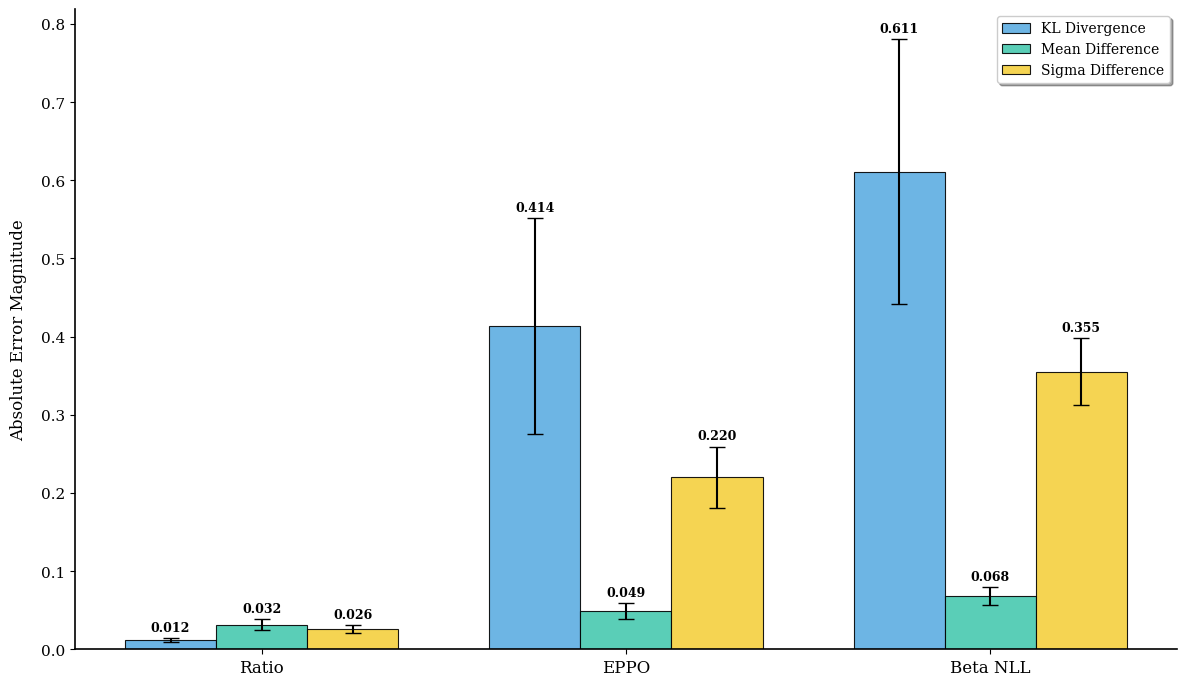

In [21]:
# @title Plot results
import matplotlib.pyplot as plt
import numpy as np

data = {
    'Ratio': [ratio_kl_divs, ratio_mu, ratio_sigma],
    'EPPO': [eppo_kl_divs, eppo_mu, eppo_sigma],
    'Beta NLL': [beta_nll_kl_divs, beta_nll_mu, beta_nll_sigma]
}

metrics = ['KL Divergence', 'Mean Difference', 'Sigma Difference']
methods = list(data.keys())

means = {metric: [] for metric in metrics}
errors = {metric: [] for metric in metrics}

for method in methods:
    for i, metric in enumerate(metrics):
        arr = np.array(data[method][i])
        avg = np.mean(arr)
        ci = 1.96 * (np.std(arr, ddof=1) / np.sqrt(len(arr)))

        means[metric].append(avg)
        errors[metric].append(ci)

plt.rcParams.update({'font.family': 'serif', 'font.size': 11})

colors = ['#5DADE2', '#48C9B0', '#F4D03F']

x = np.arange(len(methods))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 7))

for i, metric in enumerate(metrics):
    offset = width * multiplier
    rects = ax.bar(x + offset, means[metric], width, yerr=errors[metric],
                   label=metric, capsize=6, color=colors[i],
                   edgecolor='black', linewidth=0.8, alpha=0.9)
    ax.bar_label(rects, padding=3, fmt='%.3f', fontweight='bold', fontsize=9)
    multiplier += 1

#ax.set_title('Distribution Modeling Effectiveness by Method', fontsize=16, pad=25, fontweight='bold')
ax.set_ylabel('Absolute Error Magnitude', fontsize=12, labelpad=10)
ax.set_xticks(x + width, methods, fontsize=12)

ax.legend(loc='upper right', frameon=True, fontsize=10, shadow=True)
ax.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.tight_layout()
plt.savefig('comparison_plot.png', dpi=300)
plt.show()

# Experiment for advantage calculation

In [28]:
# @title TwoPairEnv
import gymnasium as gym
from gymnasium.spaces import Box, Discrete

class TwoPairEnv(gym.Env):
    '''
      0 -> 1/2 (u=1/2, sd=1)
      3 -> 4/5 (u=.1/.2, sd=.1)
    '''
    def __init__(self, config={}):
        super().__init__()
        self.sc = 6
        self.reward_map = config['reward_map']
        self.observation_space = gym.spaces.Dict({
            ACTION_MASK: Box(0.0, 1.0, shape=(self.sc,)), # 0=finish, 1...=goto state
            OBSERVATIONS: Box(0.0, 1.0, shape=(self.sc,)),
        })
        self.action_space = Discrete(self.sc)

    def get_obs(self):
        obs, am = np.zeros((self.sc),), np.zeros((self.sc),)
        obs[self.state] = 1.
        if (self.state==0):
          am[1] = am[2] = 1.
        elif (self.state==3):
          am[4] = am[5] = 1.
        else:
          am[0] = 1.
        return {
            ACTION_MASK: am,
            OBSERVATIONS: obs,
        }

    def reset(self, *, seed=None, options=None):
        self.state = 0 if np.random.rand()<.5 else 3
        return self.get_obs(), {}  # <- empty infos dict

    def step(self, action):
        reward = 0
        terminated = False
        if (self.state==0 or self.state==3):
          self.state=action
        else:
          terminated = True
          u, sd = self.reward_map[self.state] # state zero is the starting state
          reward = np.random.normal(u, sd)
        return self.get_obs(), reward, terminated, False, {}

In [ ]:
# @title Experiment (Run N times)
num_trials = 100 # @param {"type":"integer"}
baseline = False # @param {"type":"boolean"}
adv_calc_strategy = "learned_sigma" # @param ["basic","learned_sigma","probabilistic"]

ADV_CALC_BASIC

top_error_rates = []
big_error_rates = []
small_error_rates = []

for i in range(num_trials):
  print(f"Trial {i}:")
  # Two pairs of doors, one with mu and sigma in (0,1), (0,1e-3 in the other)
  reward_map = {
      1: np.random.random(size=2,),
      2: np.random.random(size=2,),
      4: np.random.random(size=2,)*1e-3,
      5: np.random.random(size=2,)*1e-3,
  }
  config = (
      PPOConfig()
      .environment(target_env, env_config={
          'reward_map': reward_map
      })
      .env_runners(
          num_env_runners=0,
          num_envs_per_env_runner=1,
      )
      .callbacks(
          functools.partial(LogActionsCallback, action_lambda=lambda: [1,2,4,5])
      )
      .training(
          lr=1e-4,
          train_batch_size=200,
      )
  )
  if (baseline):
    # Run standard PPO
    config.rl_module(
        rl_module_spec=RLModuleSpec(
            module_class=ActionMaskingTorchRLModule,
            model_config={
                "head_fcnet_hiddens": (32,),
            }
        )
    )
  else:
    # Run probabilistic PPO
    config.learners(
        learner_class=ProbValueTorchLearner,
        learner_config_dict={
            "critic_loss_strategy": 'ratio',
            "adv_calc_strategy": adv_calc_strategy,
        },
    )
    config.rl_module(
        rl_module_spec=RLModuleSpec(
            catalog_class=ProbValuePPOCatalog,
            module_class=ProbValue_AMTorchRLModule,
            model_config={
                "head_fcnet_hiddens": (32,),
            }
        )
    )

  algo = config.build_algo()

  # Train
  num_iters = 10

  for i in range(num_iters):
    results = algo.train()
    if ENV_RUNNER_RESULTS in results:
        mean_return = results[ENV_RUNNER_RESULTS].get(
            'episode_return_mean', np.nan
        )
        vf_loss = results['learners'][DEFAULT_POLICY_ID]['vf_loss']
        # What actions are we getting?
        actions = np.array([results[ENV_RUNNER_RESULTS][f'player_action_{i}'] for i in [1,2,4,5]])
        actions = actions / actions.sum()

        #
        if (i==num_iters-1):
          # Suboptimalities (get the largest mistake percentage out of both pairs)
          pair_1_subopt = actions[0] if reward_map[1][0]<reward_map[2][0] else actions[1]
          pair_1_subopt /= (actions[0]+actions[1])
          pair_2_subopt = actions[2] if reward_map[4][0]<reward_map[5][0] else actions[3]
          pair_2_subopt /= (actions[2]+actions[3])
          print(f'p1so: {pair_1_subopt:.2f} p2so: {pair_2_subopt:.2f}')
          top_error_rates.append(np.max([pair_1_subopt, pair_2_subopt]))
          big_error_rates.append(pair_1_subopt)
          small_error_rates.append(pair_2_subopt)
          #
          actions = ', '.join([f'{a:.2f}' for a in actions])
          rewards = ', '.join([f'{reward_map[a][0]:.4f}' for a in [1,2,4,5]])
          print(f"iter={i+1} VF loss={vf_loss:.2f} R={mean_return:.2f}\naction distr=[{actions}] reward_distr=[{rewards}]")

print(f"Baseline: {baseline}")
print(f"Mean (std) top error rate: {np.mean(top_error_rates):.2f} ({np.std(top_error_rates):.2f})")
print(f"Mean (std) left (0 to 1) error rate: {np.mean(big_error_rates):.2f} ({np.std(big_error_rates):.2f})")
print(f"Mean (std) right (0 to 1e-3) error rate: {np.mean(small_error_rates):.2f} ({np.std(small_error_rates):.2f})")
print('-'*20 + " top_error_rates")
print(top_error_rates)
print('-'*20 + " big_error_rates")
print(big_error_rates)
print('-'*20 + " small_error_rates")
print(small_error_rates)

In [31]:
# @title Data inputs
baseline_top_error_rates = [np.float64(0.22641509433962262), np.float64(0.0), np.float64(0.38888888888888884), np.float64(0.17307692307692307), np.float64(0.2926829268292683), np.float64(0.8392857142857143), np.float64(0.7894736842105262), np.float64(0.5348837209302325), np.float64(0.6363636363636364), np.float64(0.47058823529411764), np.float64(0.38461538461538464), np.float64(0.8913043478260869), np.float64(0.88), np.float64(1.0), np.float64(0.5102040816326531), np.float64(0.2653061224489796), np.float64(0.45283018867924524), np.float64(0.40425531914893614), np.float64(0.4166666666666667), np.float64(0.125), np.float64(0.4339622641509434), np.float64(0.07407407407407407), np.float64(0.3448275862068965), np.float64(0.8913043478260869), np.float64(0.16071428571428573), np.float64(0.6086956521739131), np.float64(0.8846153846153846), np.float64(0.056603773584905655), np.float64(1.0), np.float64(0.9743589743589743), np.float64(0.5531914893617021), np.float64(0.6808510638297873), np.float64(0.28), np.float64(0.7317073170731708), np.float64(0.5869565217391305), np.float64(0.5), np.float64(0.3), np.float64(0.7454545454545454), np.float64(0.47727272727272724), np.float64(0.6170212765957447), np.float64(0.41818181818181815), np.float64(0.5), np.float64(0.5714285714285715), np.float64(0.2962962962962963), np.float64(0.3617021276595745), np.float64(0.3673469387755102), np.float64(0.8444444444444444), np.float64(0.9464285714285714), np.float64(0.3214285714285714), np.float64(0.7115384615384615), np.float64(0.6944444444444444), np.float64(0.6938775510204083), np.float64(0.39583333333333337), np.float64(0.7021276595744681), np.float64(0.5490196078431373), np.float64(0.10344827586206895), np.float64(0.9122807017543859), np.float64(0.639344262295082), np.float64(0.6744186046511628), np.float64(0.68), np.float64(0.34090909090909094), np.float64(0.42857142857142855), np.float64(0.6326530612244898), np.float64(0.717391304347826), np.float64(0.6274509803921569), np.float64(0.1951219512195122), np.float64(0.20754716981132076), np.float64(0.6666666666666667), np.float64(0.06666666666666667), np.float64(0.76), np.float64(1.0), np.float64(0.019230769230769232), np.float64(0.16666666666666666), np.float64(0.2608695652173913), np.float64(0.7083333333333334), np.float64(0.5666666666666667), np.float64(0.3829787234042553), np.float64(0.5614035087719298), np.float64(0.2916666666666667), np.float64(0.6), np.float64(0.8478260869565217), np.float64(0.8), np.float64(0.8571428571428571), np.float64(0.23636363636363636), np.float64(0.2549019607843137), np.float64(0.08695652173913045), np.float64(0.7647058823529412), np.float64(0.48214285714285715), np.float64(0.6571428571428573), np.float64(0.9803921568627451), np.float64(0.2608695652173913), np.float64(0.4318181818181818), np.float64(0.5254237288135593), np.float64(0.7857142857142857), np.float64(0.38461538461538464), np.float64(0.8979591836734694), np.float64(0.9038461538461537), np.float64(0.6153846153846154), np.float64(0.6521739130434783), np.float64(0.6862745098039215)] # @param {"type":"raw"}
baseline_big_error_rates = [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.17307692307692307), np.float64(0.0), np.float64(0.0), np.float64(0.046511627906976744), np.float64(0.0), np.float64(0.017857142857142856), np.float64(0.020408163265306124), np.float64(0.3125), np.float64(0.0), np.float64(0.88), np.float64(0.7037037037037037), np.float64(0.058823529411764705), np.float64(0.058823529411764705), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.022727272727272728), np.float64(0.48148148148148145), np.float64(0.0), np.float64(0.0), np.float64(0.01724137931034483), np.float64(0.01639344262295082), np.float64(0.3584905660377358), np.float64(0.0), np.float64(0.24), np.float64(0.01694915254237288), np.float64(0.0), np.float64(0.018518518518518517), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.02380952380952381), np.float64(0.0196078431372549), np.float64(0.06521739130434782), np.float64(0.0), np.float64(0.0196078431372549), np.float64(0.0), np.float64(0.9464285714285714), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.09523809523809525), np.float64(0.0), np.float64(0.05128205128205128), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0196078431372549), np.float64(0.5686274509803921), np.float64(0.0), np.float64(0.020408163265306124), np.float64(0.050847457627118633), np.float64(0.0851063829787234), np.float64(0.019230769230769232), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.018518518518518517), np.float64(0.019230769230769232), np.float64(0.049999999999999996), np.float64(0.018867924528301886), np.float64(0.5614035087719298), np.float64(0.05769230769230769), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0196078431372549), np.float64(0.0), np.float64(0.0), np.float64(0.018518518518518517), np.float64(0.7647058823529412), np.float64(0.0), np.float64(0.015384615384615384), np.float64(0.0), np.float64(0.0), np.float64(0.03571428571428571), np.float64(0.024390243902439022), np.float64(0.045454545454545456), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.018518518518518517), np.float64(0.0)] # @param {"type":"raw"}
baseline_small_error_rates = [np.float64(0.22641509433962262), np.float64(0.0), np.float64(0.38888888888888884), np.float64(0.041666666666666664), np.float64(0.2926829268292683), np.float64(0.8392857142857143), np.float64(0.7894736842105262), np.float64(0.5348837209302325), np.float64(0.6363636363636364), np.float64(0.47058823529411764), np.float64(0.38461538461538464), np.float64(0.8913043478260869), np.float64(0.24), np.float64(1.0), np.float64(0.5102040816326531), np.float64(0.2653061224489796), np.float64(0.45283018867924524), np.float64(0.40425531914893614), np.float64(0.4166666666666667), np.float64(0.125), np.float64(0.4339622641509434), np.float64(0.07407407407407407), np.float64(0.3448275862068965), np.float64(0.8913043478260869), np.float64(0.16071428571428573), np.float64(0.6086956521739131), np.float64(0.8846153846153846), np.float64(0.056603773584905655), np.float64(1.0), np.float64(0.9743589743589743), np.float64(0.5531914893617021), np.float64(0.6808510638297873), np.float64(0.28), np.float64(0.7317073170731708), np.float64(0.5869565217391305), np.float64(0.5), np.float64(0.3), np.float64(0.7454545454545454), np.float64(0.47727272727272724), np.float64(0.6170212765957447), np.float64(0.41818181818181815), np.float64(0.5), np.float64(0.5714285714285715), np.float64(0.2962962962962963), np.float64(0.3617021276595745), np.float64(0.3673469387755102), np.float64(0.8444444444444444), np.float64(0.4318181818181818), np.float64(0.3214285714285714), np.float64(0.7115384615384615), np.float64(0.6944444444444444), np.float64(0.6938775510204083), np.float64(0.39583333333333337), np.float64(0.7021276595744681), np.float64(0.5490196078431373), np.float64(0.10344827586206895), np.float64(0.9122807017543859), np.float64(0.639344262295082), np.float64(0.6744186046511628), np.float64(0.68), np.float64(0.34090909090909094), np.float64(0.42857142857142855), np.float64(0.6326530612244898), np.float64(0.717391304347826), np.float64(0.6274509803921569), np.float64(0.1951219512195122), np.float64(0.20754716981132076), np.float64(0.6666666666666667), np.float64(0.06666666666666667), np.float64(0.76), np.float64(0.22222222222222227), np.float64(0.019230769230769232), np.float64(0.16666666666666666), np.float64(0.2608695652173913), np.float64(0.7083333333333334), np.float64(0.5666666666666667), np.float64(0.3829787234042553), np.float64(0.5116279069767442), np.float64(0.2916666666666667), np.float64(0.6), np.float64(0.8478260869565217), np.float64(0.8), np.float64(0.8571428571428571), np.float64(0.23636363636363636), np.float64(0.2549019607843137), np.float64(0.08695652173913045), np.float64(0.4897959183673469), np.float64(0.48214285714285715), np.float64(0.6571428571428573), np.float64(0.9803921568627451), np.float64(0.2608695652173913), np.float64(0.4318181818181818), np.float64(0.5254237288135593), np.float64(0.7857142857142857), np.float64(0.38461538461538464), np.float64(0.8979591836734694), np.float64(0.9038461538461537), np.float64(0.6153846153846154), np.float64(0.6521739130434783), np.float64(0.6862745098039215)] # @param {"type":"raw"}

expr_top_error_rates = [np.float64(0.7037037037037037), np.float64(0.5964912280701754), np.float64(0.4909090909090909), np.float64(0.7755102040816326), np.float64(0.537037037037037), np.float64(0.723404255319149), np.float64(0.15555555555555556), np.float64(0.2833333333333334), np.float64(0.9803921568627451), np.float64(0.8148148148148148), np.float64(0.0), np.float64(0.0196078431372549), np.float64(0.2391304347826087), np.float64(1.0), np.float64(0.24489795918367346), np.float64(0.7291666666666666), np.float64(0.9130434782608696), np.float64(0.18518518518518517), np.float64(0.6), np.float64(0.09615384615384616), np.float64(0.2), np.float64(0.11320754716981131), np.float64(0.14893617021276595), np.float64(0.39583333333333337), np.float64(0.10909090909090907), np.float64(0.3913043478260869), np.float64(0.38461538461538464), np.float64(0.4791666666666667), np.float64(0.29411764705882354), np.float64(0.9032258064516129), np.float64(0.2553191489361702), np.float64(0.5531914893617021), np.float64(0.4137931034482758), np.float64(0.3023255813953489), np.float64(0.5), np.float64(0.5384615384615385), np.float64(0.33962264150943394), np.float64(0.3620689655172414), np.float64(0.018867924528301886), np.float64(0.30357142857142855), np.float64(0.0), np.float64(0.6862745098039215), np.float64(0.8163265306122449), np.float64(0.3023255813953489), np.float64(0.7543859649122806), np.float64(0.5098039215686274), np.float64(0.368421052631579), np.float64(0.39285714285714285), np.float64(0.09433962264150944), np.float64(0.6595744680851064), np.float64(0.6470588235294118), np.float64(0.7804878048780488), np.float64(0.2978723404255319), np.float64(0.6557377049180328), np.float64(0.6428571428571429), np.float64(0.45454545454545453), np.float64(0.38), np.float64(0.0), np.float64(0.0425531914893617), np.float64(0.76), np.float64(0.5357142857142857), np.float64(0.34), np.float64(0.11764705882352941), np.float64(0.10869565217391305), np.float64(0.7169811320754716), np.float64(0.7777777777777777), np.float64(0.31818181818181823), np.float64(0.5098039215686274), np.float64(0.23529411764705882), np.float64(0.86), np.float64(0.35000000000000003), np.float64(0.056603773584905655), np.float64(0.12068965517241378), np.float64(0.8478260869565217), np.float64(0.07692307692307691), np.float64(0.0), np.float64(0.061224489795918366), np.float64(0.10526315789473682), np.float64(0.34), np.float64(0.3269230769230769), np.float64(0.9583333333333333), np.float64(0.575), np.float64(0.4363636363636363), np.float64(0.9148936170212766), np.float64(0.28), np.float64(0.9555555555555555), np.float64(0.0625), np.float64(0.851063829787234), np.float64(0.23404255319148937), np.float64(0.4067796610169492), np.float64(0.09433962264150944), np.float64(0.6585365853658537), np.float64(0.054545454545454536), np.float64(0.6808510638297873), np.float64(0.5614035087719298), np.float64(1.0), np.float64(0.76), np.float64(0.163265306122449), np.float64(0.82), np.float64(0.7192982456140351)] # @param {"type":"raw"}
expr_big_error_rates = [np.float64(0.043478260869565216), np.float64(0.5964912280701754), np.float64(0.0), np.float64(0.09803921568627451), np.float64(0.15217391304347827), np.float64(0.056603773584905655), np.float64(0.054545454545454536), np.float64(0.22499999999999998), np.float64(0.24489795918367346), np.float64(0.8148148148148148), np.float64(0.0), np.float64(0.0196078431372549), np.float64(0.018518518518518517), np.float64(0.0), np.float64(0.0196078431372549), np.float64(0.7291666666666666), np.float64(0.0), np.float64(0.0), np.float64(0.04), np.float64(0.0), np.float64(0.0), np.float64(0.11320754716981131), np.float64(0.018867924528301886), np.float64(0.019230769230769232), np.float64(0.0), np.float64(0.3913043478260869), np.float64(0.020833333333333336), np.float64(0.019230769230769232), np.float64(0.29411764705882354), np.float64(0.05263157894736842), np.float64(0.2553191489361702), np.float64(0.0), np.float64(0.09523809523809525), np.float64(0.3023255813953489), np.float64(0.38461538461538464), np.float64(0.08333333333333334), np.float64(0.33962264150943394), np.float64(0.0), np.float64(0.018867924528301886), np.float64(0.0), np.float64(0.0), np.float64(0.24489795918367346), np.float64(0.11764705882352941), np.float64(0.0), np.float64(0.0697674418604651), np.float64(0.020408163265306124), np.float64(0.0), np.float64(0.0), np.float64(0.0425531914893617), np.float64(0.07547169811320754), np.float64(0.6470588235294118), np.float64(0.6949152542372881), np.float64(0.0), np.float64(0.02564102564102564), np.float64(0.34090909090909094), np.float64(0.0), np.float64(0.08), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.11363636363636365), np.float64(0.24), np.float64(0.0816326530612245), np.float64(0.09259259259259259), np.float64(0.425531914893617), np.float64(0.5652173913043478), np.float64(0.0), np.float64(0.0), np.float64(0.04081632653061225), np.float64(0.86), np.float64(0.35000000000000003), np.float64(0.0), np.float64(0.12068965517241378), np.float64(0.2962962962962963), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.02), np.float64(0.1875), np.float64(0.4615384615384615), np.float64(0.016666666666666666), np.float64(0.4363636363636363), np.float64(0.0), np.float64(0.0), np.float64(0.01818181818181818), np.float64(0.0), np.float64(0.24528301886792453), np.float64(0.0), np.float64(0.4067796610169492), np.float64(0.0), np.float64(0.050847457627118633), np.float64(0.022222222222222223), np.float64(0.03773584905660377), np.float64(0.046511627906976744), np.float64(0.0), np.float64(0.02), np.float64(0.0), np.float64(0.04), np.float64(0.7192982456140351)] # @param {"type":"raw"}
expr_small_error_rates = [np.float64(0.7037037037037037), np.float64(0.5348837209302325), np.float64(0.4909090909090909), np.float64(0.7755102040816326), np.float64(0.537037037037037), np.float64(0.723404255319149), np.float64(0.15555555555555556), np.float64(0.2833333333333334), np.float64(0.9803921568627451), np.float64(0.32608695652173914), np.float64(0.0), np.float64(0.0), np.float64(0.2391304347826087), np.float64(1.0), np.float64(0.24489795918367346), np.float64(0.6923076923076923), np.float64(0.9130434782608696), np.float64(0.18518518518518517), np.float64(0.6), np.float64(0.09615384615384616), np.float64(0.2), np.float64(0.02127659574468085), np.float64(0.14893617021276595), np.float64(0.39583333333333337), np.float64(0.10909090909090907), np.float64(0.37037037037037035), np.float64(0.38461538461538464), np.float64(0.4791666666666667), np.float64(0.24489795918367346), np.float64(0.9032258064516129), np.float64(0.11320754716981131), np.float64(0.5531914893617021), np.float64(0.4137931034482758), np.float64(0.14035087719298248), np.float64(0.5), np.float64(0.5384615384615385), np.float64(0.02127659574468085), np.float64(0.3620689655172414), np.float64(0.0), np.float64(0.30357142857142855), np.float64(0.0), np.float64(0.6862745098039215), np.float64(0.8163265306122449), np.float64(0.3023255813953489), np.float64(0.7543859649122806), np.float64(0.5098039215686274), np.float64(0.368421052631579), np.float64(0.39285714285714285), np.float64(0.09433962264150944), np.float64(0.6595744680851064), np.float64(0.22448979591836735), np.float64(0.7804878048780488), np.float64(0.2978723404255319), np.float64(0.6557377049180328), np.float64(0.6428571428571429), np.float64(0.45454545454545453), np.float64(0.38), np.float64(0.0), np.float64(0.0425531914893617), np.float64(0.76), np.float64(0.5357142857142857), np.float64(0.34), np.float64(0.11764705882352941), np.float64(0.10869565217391305), np.float64(0.7169811320754716), np.float64(0.7777777777777777), np.float64(0.31818181818181823), np.float64(0.5098039215686274), np.float64(0.23529411764705882), np.float64(0.06), np.float64(0.0), np.float64(0.056603773584905655), np.float64(0.02380952380952381), np.float64(0.8478260869565217), np.float64(0.07692307692307691), np.float64(0.0), np.float64(0.061224489795918366), np.float64(0.10526315789473682), np.float64(0.34), np.float64(0.3269230769230769), np.float64(0.9583333333333333), np.float64(0.575), np.float64(0.37777777777777777), np.float64(0.9148936170212766), np.float64(0.28), np.float64(0.9555555555555555), np.float64(0.0625), np.float64(0.851063829787234), np.float64(0.23404255319148937), np.float64(0.12195121951219513), np.float64(0.09433962264150944), np.float64(0.6585365853658537), np.float64(0.054545454545454536), np.float64(0.6808510638297873), np.float64(0.5614035087719298), np.float64(1.0), np.float64(0.76), np.float64(0.163265306122449), np.float64(0.82), np.float64(0.34883720930232553)] # @param {"type":"raw"}

middle_top_error_rates = [np.float64(0.2692307692307693), np.float64(0.48), np.float64(0.20967741935483872), np.float64(0.16071428571428573), np.float64(0.9824561403508771), np.float64(0.9130434782608696), np.float64(0.03571428571428571), np.float64(0.2916666666666667), np.float64(0.6), np.float64(0.5625000000000001), np.float64(0.22033898305084743), np.float64(0.6981132075471698), np.float64(0.43478260869565216), np.float64(0.0), np.float64(0.06), np.float64(0.25), np.float64(0.4716981132075471), np.float64(0.2758620689655173), np.float64(0.27777777777777773), np.float64(0.13333333333333333), np.float64(0.9387755102040817), np.float64(0.18000000000000002), np.float64(0.10416666666666667), np.float64(0.45238095238095233), np.float64(0.05769230769230769), np.float64(0.653061224489796), np.float64(0.6444444444444445), np.float64(0.33333333333333337), np.float64(0.7), np.float64(0.23404255319148937), np.float64(0.39024390243902435), np.float64(0.0), np.float64(0.1702127659574468), np.float64(1.0), np.float64(1.0), np.float64(0.0), np.float64(0.4716981132075471), np.float64(0.46938775510204084), np.float64(0.08695652173913045), np.float64(0.27450980392156865), np.float64(0.38), np.float64(0.2916666666666667), np.float64(0.1), np.float64(0.05555555555555555), np.float64(0.8135593220338984), np.float64(0.5957446808510638), np.float64(0.08620689655172413), np.float64(0.8571428571428572), np.float64(0.16666666666666666), np.float64(0.2444444444444444), np.float64(0.0625), np.float64(0.0392156862745098), np.float64(0.07142857142857142), np.float64(0.37037037037037035), np.float64(0.82), np.float64(0.5813953488372093), np.float64(0.08333333333333334), np.float64(0.6315789473684211), np.float64(0.1320754716981132), np.float64(0.34615384615384615), np.float64(0.9722222222222222), np.float64(0.13461538461538464), np.float64(0.5), np.float64(0.6136363636363636), np.float64(0.5319148936170213), np.float64(0.5319148936170213), np.float64(0.6140350877192983), np.float64(0.49019607843137253), np.float64(0.16), np.float64(0.044444444444444446), np.float64(0.44), np.float64(0.3125), np.float64(0.48275862068965514), np.float64(0.6415094339622641), np.float64(0.5294117647058824), np.float64(0.046511627906976744), np.float64(0.3709677419354839), np.float64(0.2727272727272727), np.float64(0.39583333333333337), np.float64(0.43478260869565216), np.float64(0.09615384615384616), np.float64(0.22641509433962265), np.float64(0.574468085106383), np.float64(0.125), np.float64(0.041666666666666664), np.float64(1.0), np.float64(0.11764705882352941), np.float64(0.2727272727272727), np.float64(0.375), np.float64(0.2641509433962264), np.float64(0.611111111111111), np.float64(0.6981132075471698), np.float64(0.5686274509803921), np.float64(0.25), np.float64(0.359375), np.float64(0.13461538461538464), np.float64(0.020833333333333336), np.float64(0.34), np.float64(0.3125), np.float64(0.22916666666666669)] # @param {"type":"raw"}
middle_big_error_rates = [np.float64(0.2692307692307693), np.float64(0.2), np.float64(0.02631578947368421), np.float64(0.022727272727272728), np.float64(0.11627906976744187), np.float64(0.14814814814814814), np.float64(0.03571428571428571), np.float64(0.038461538461538464), np.float64(0.08), np.float64(0.5625000000000001), np.float64(0.0), np.float64(0.0), np.float64(0.43478260869565216), np.float64(0.0), np.float64(0.0), np.float64(0.019230769230769232), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.054545454545454536), np.float64(0.6862745098039215), np.float64(0.020000000000000004), np.float64(0.0), np.float64(0.01724137931034483), np.float64(0.0), np.float64(0.1764705882352941), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.01694915254237288), np.float64(0.0), np.float64(0.0), np.float64(0.09259259259259259), np.float64(0.17307692307692307), np.float64(0.0), np.float64(0.4716981132075471), np.float64(0.0), np.float64(0.018518518518518517), np.float64(0.27450980392156865), np.float64(0.0), np.float64(0.0), np.float64(0.04), np.float64(0.0), np.float64(0.048780487804878044), np.float64(0.0), np.float64(0.08620689655172413), np.float64(0.017241379310344827), np.float64(0.0), np.float64(0.01818181818181818), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.041666666666666664), np.float64(0.0625), np.float64(0.13461538461538464), np.float64(0.021739130434782608), np.float64(0.4464285714285714), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.49019607843137253), np.float64(0.0), np.float64(0.01818181818181818), np.float64(0.0), np.float64(0.3125), np.float64(0.0), np.float64(0.0), np.float64(0.5102040816326531), np.float64(0.046511627906976744), np.float64(0.0), np.float64(0.0), np.float64(0.019230769230769232), np.float64(0.0), np.float64(0.09615384615384616), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.019230769230769232), np.float64(0.10204081632653061), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.2641509433962264), np.float64(0.611111111111111), np.float64(0.425531914893617), np.float64(0.0), np.float64(0.25), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.22916666666666669)] # @param {"type":"raw"}
middle_small_error_rates = [np.float64(0.020833333333333336), np.float64(0.48), np.float64(0.20967741935483872), np.float64(0.16071428571428573), np.float64(0.9824561403508771), np.float64(0.9130434782608696), np.float64(0.0), np.float64(0.2916666666666667), np.float64(0.6), np.float64(0.13461538461538464), np.float64(0.22033898305084743), np.float64(0.6981132075471698), np.float64(0.37037037037037035), np.float64(0.0), np.float64(0.06), np.float64(0.25), np.float64(0.4716981132075471), np.float64(0.2758620689655173), np.float64(0.27777777777777773), np.float64(0.13333333333333333), np.float64(0.9387755102040817), np.float64(0.18000000000000002), np.float64(0.10416666666666667), np.float64(0.45238095238095233), np.float64(0.05769230769230769), np.float64(0.653061224489796), np.float64(0.6444444444444445), np.float64(0.33333333333333337), np.float64(0.7), np.float64(0.23404255319148937), np.float64(0.39024390243902435), np.float64(0.0), np.float64(0.1702127659574468), np.float64(1.0), np.float64(1.0), np.float64(0.0), np.float64(0.3829787234042553), np.float64(0.46938775510204084), np.float64(0.08695652173913045), np.float64(0.0), np.float64(0.38), np.float64(0.2916666666666667), np.float64(0.1), np.float64(0.05555555555555555), np.float64(0.8135593220338984), np.float64(0.5957446808510638), np.float64(0.047619047619047616), np.float64(0.8571428571428572), np.float64(0.16666666666666666), np.float64(0.2444444444444444), np.float64(0.0625), np.float64(0.0392156862745098), np.float64(0.07142857142857142), np.float64(0.37037037037037035), np.float64(0.82), np.float64(0.5813953488372093), np.float64(0.08333333333333334), np.float64(0.6315789473684211), np.float64(0.1320754716981132), np.float64(0.34615384615384615), np.float64(0.9722222222222222), np.float64(0.0625), np.float64(0.5), np.float64(0.6136363636363636), np.float64(0.5319148936170213), np.float64(0.5319148936170213), np.float64(0.6140350877192983), np.float64(0.061224489795918366), np.float64(0.16), np.float64(0.044444444444444446), np.float64(0.44), np.float64(0.09615384615384616), np.float64(0.48275862068965514), np.float64(0.6415094339622641), np.float64(0.5294117647058824), np.float64(0.03508771929824561), np.float64(0.3709677419354839), np.float64(0.2727272727272727), np.float64(0.39583333333333337), np.float64(0.43478260869565216), np.float64(0.0), np.float64(0.22641509433962265), np.float64(0.574468085106383), np.float64(0.125), np.float64(0.041666666666666664), np.float64(1.0), np.float64(0.11764705882352941), np.float64(0.2727272727272727), np.float64(0.375), np.float64(0.0), np.float64(0.41304347826086957), np.float64(0.6981132075471698), np.float64(0.5686274509803921), np.float64(0.09090909090909091), np.float64(0.359375), np.float64(0.13461538461538464), np.float64(0.020833333333333336), np.float64(0.34), np.float64(0.3125), np.float64(0.019230769230769232)] # @param {"type":"raw"}

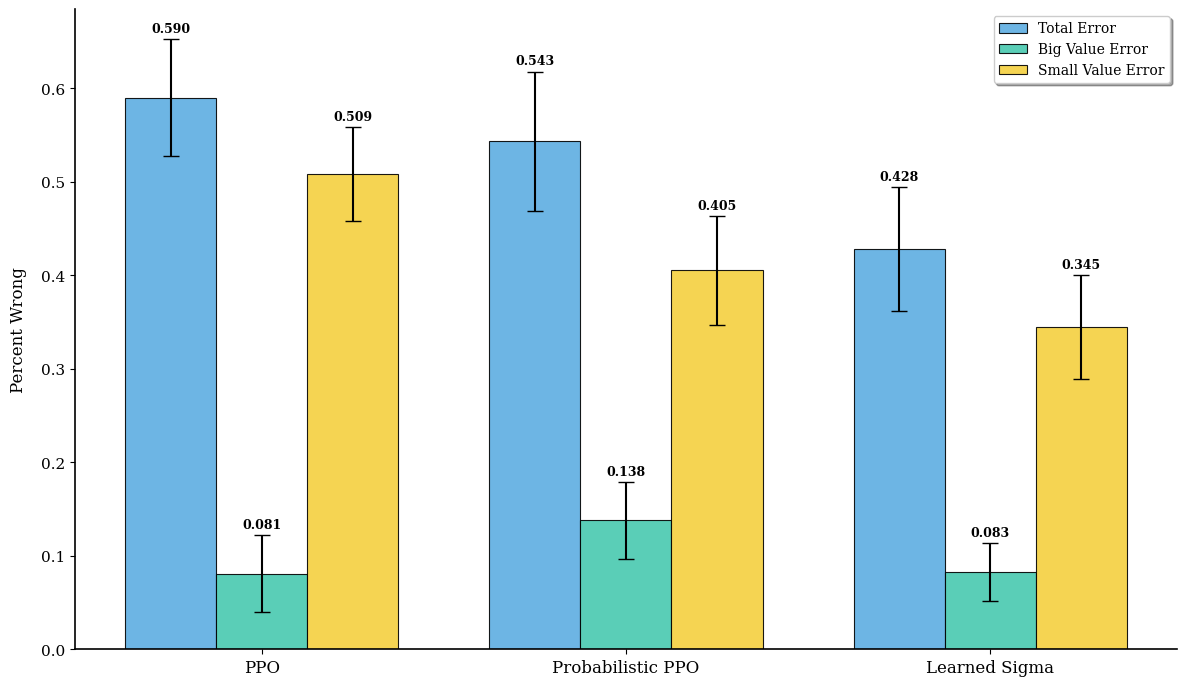

In [32]:
# @title Plot results
import matplotlib.pyplot as plt
import numpy as np

data = {
    'PPO': [np.array(baseline_big_error_rates)+np.array(baseline_small_error_rates), baseline_big_error_rates, baseline_small_error_rates],
    'Probabilistic PPO': [np.array(expr_big_error_rates)+np.array(expr_small_error_rates), expr_big_error_rates, expr_small_error_rates],
    'Learned Sigma': [np.array(middle_big_error_rates)+np.array(middle_small_error_rates), middle_big_error_rates, middle_small_error_rates],
}

metrics = ['Total Error', 'Big Value Error', 'Small Value Error']
methods = list(data.keys())

means = {metric: [] for metric in metrics}
errors = {metric: [] for metric in metrics}

for method in methods:
    for i, metric in enumerate(metrics):
        arr = np.array(data[method][i])
        avg = np.mean(arr)
        ci = 1.96 * (np.std(arr, ddof=1) / np.sqrt(len(arr)))

        means[metric].append(avg)
        errors[metric].append(ci)

plt.rcParams.update({'font.family': 'serif', 'font.size': 11})

colors = ['#5DADE2', '#48C9B0', '#F4D03F']

x = np.arange(len(methods))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 7))

for i, metric in enumerate(metrics):
    offset = width * multiplier
    rects = ax.bar(x + offset, means[metric], width, yerr=errors[metric],
                   label=metric, capsize=6, color=colors[i],
                   edgecolor='black', linewidth=0.8, alpha=0.9)
    ax.bar_label(rects, padding=3, fmt='%.3f', fontweight='bold', fontsize=9)
    multiplier += 1

#ax.set_title('Distribution Modeling Effectiveness by Method', fontsize=16, pad=25, fontweight='bold')
ax.set_ylabel('Percent Wrong', fontsize=12, labelpad=10)
ax.set_xticks(x + width, methods, fontsize=12)

ax.legend(loc='upper right', frameon=True, fontsize=10, shadow=True)
ax.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.tight_layout()
plt.savefig('comparison_plot.png', dpi=300)
plt.show()